# Predictive description model of loan_status from Lending Club Loan Data 

## Michał Pietruszka, 03.07.2017 - 17.07.2017

#### Data: https://www.kaggle.com/wendykan/lending-club-loan-data/downloads/lending-club-loan-data.zip
#### Task:  Prepare predictive model(s) of default. Default client is defined as one with loan_status variable taking on the following levels:
    - charged off
    - default
    - does not meet the credit policy. Status: Charged Off
    - late (31-120 days)
#### Test set: 30% randomly selected clients from the original dataset.

# Table of Contents:

## 1. Importing a DataFrame

## 2. Defining functions
You can investigate my programmic skills by reading these lines of code that are helpful in next steps
## 3. Data exploration 
Plotting histograms, conditional histograms as well as searching for most important variables and counting missing values.
## 4. Cleanup and Transform the Data
Dropping unnecessary columns, converting to numerical, filling missing values, creating new features, feature engineering, feature hand-tuning, investigating true meaning of feature and final encoding
## 5. Models training
I define models, train them, verify results and compare them.
Models used: AdaBoost, GradientBoost, RandomForrest, KNearestNeighbours
At the end I also present ROC Curves with AUC as well as Accuracy score

#### *Final note* Chapter 4. is the most meaningful due to data preprocessing and feature exploration. I also added my own features that are important for  final outcome.





# START

## 1. Importing a DataFrame

In [1]:
## Original Kaggle header-cell:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)|
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [2]:
# Importing basic libraries to work
pd.set_option('display.max_columns', None)
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
from matplotlib import interactive
import seaborn as sns

from scipy.stats import binned_statistic
import math
import matplotlib
# Printing important developers informations
print(sys.version)
matplotlib.get_backend()

3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]


'module://ipykernel.pylab.backend_inline'

In [3]:
# Setting parameters for images
sns.set(rc={"figure.figsize": (6, 6)})
interactive(True)
%matplotlib inline
width = 6
height = 6
plt.figure(figsize=(width, height), dpi= 600)
matplotlib.rcParams['figure.figsize']= [6, 6]

In [4]:
# Reading data from .csv
#data_nrows=200000  # for 32bit python version this is somewhere near the memory limit

#data= pd.read_csv('input/loan.csv',low_memory=False, nrows=data_nrows)
data= pd.read_csv('input/loan.csv',low_memory=False)
# Getting rid of ids
data.drop(['id', 'member_id'], axis=1, inplace=True)

# Replacing 'n/a' with numerical
data.replace('n/a', np.nan, inplace=True)   # only in emp_length  'n/a' is in ~5% cases

# Preparing target
data['loan_status'].replace(['Charged Off', 'Default', 'Late (31-120 days)',
                             'Does not meet the credit policy. Status:Charged Off'], [1] * 4, inplace=True)
data['loan_status'].replace(['Fully Paid', 'Current', 'In Grace Period', 'Late (16-30 days)',
                             'Does not meet the credit policy. Status:Fully Paid', 'Issued'], [0] * 6, inplace=True)
loan_status = data['loan_status']
loan_status.value_counts()

data_nrows=data.shape[0]
#data_nrows

In [5]:
data_bp = pd.read_csv('input/loan.csv',low_memory=False)


In [6]:
preprocessCols = data.columns

In [7]:
# Back-uping data
data_cp = data

In [7]:
# Creating descriptions
desc = data.describe()
descObj = data.describe(include=[np.object])
descNum = data.describe(include=[np.number])

In [8]:
# I will save current column names

In [9]:
preprocessColsObj = descObj.columns
preprocessColsNum = descNum.columns

In [10]:
preprocessColsObj

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type',
       'verification_status_joint'],
      dtype='object')

In [11]:
preprocessColsNum

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'loan_status', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m'],
      dtype='object')

## 2. Defining functions

### 2.1 Binning function
Binning to specified numbers of bins, or to a defined specific bin

In [12]:
def bin_it_wisely(column_name, bins):
    # column_name - name of the feature to be simplified
    # bins - list of bin edges or number of bins
    if(type(bins)==int):
        my_funny_names = [i for i in range(0,bins)]
    else:
        my_funny_names = [i for i in range(0,len(bins)-1)]
    # Show mapping 'formula'
    print(my_funny_names)
    print(bins)
    categories = pd.cut(data[column_name], bins, labels=my_funny_names,include_lowest =True)
    #data[column_name+'_bin'] = data[column_name]
    # Assign simplified data to the same feature
    data[column_name+'_bin'] = categories
    #return data

### 2.2 Plotting defaulting probability histogram of the binned data

In [13]:
#function for plotting probability after binning data
def plot_me_proba( column_name,  numbins=20, bins=[0]):
    # column_name - name of the feature to be plotted
    # numbins - number of bins 
    # bins - list of bin edges if number of bins is zero
    plt.figure()
    if (numbins == 0):
        numbins=len(bins)
        bl=len(bins)
        # calculating bins properties
        bin_xmin = data[column_name].min()
        bin_xmax = data[column_name].max()
        bin_means = binned_statistic(data[column_name], data.loan_status, bins=bins)[0]
        bin_range = bin_xmax - bin_xmin 
        bin_width = bin_range / numbins 
        # bin will be represented graphically by its center
        bin_centers = [(bins[i] + bins[i+1]/2) for i in range(0,len(bins)-1)]
        plt_numbins=bins
    else:
        # calculating bins properties
        bin_xmin = data[column_name].min()
        bin_xmax = data[column_name].max()
        bin_means = binned_statistic(data[column_name], data.loan_status, bins=numbins)[0]
        bin_range = bin_xmax - bin_xmin 
        bin_width = bin_range / numbins 
        # bin will be represented graphically by its center
        bin_centers = [(bin_xmin + i*bin_width + 0.5*bin_width) for i in range(0, numbins)]
        plt_numbins = numbins
    # plotting probability of defaulting a loan
    plt.plot(bin_centers, bin_means,label=(str(numbins)+" bins"))
    plt.savefig(str(column_name) + '_binned_prob' + '.svg', format='svg', dpi=1200)
    plt.ylabel('Probability') 
    plt.xlabel('bins')   
    plt.title(column_name)
    plt.legend()
    plt.show()
    # plotting histograms for defaulting and not defaulting
    temp_proba = sns.FacetGrid(data, col='loan_status',size=8, aspect=1)
    temp_proba.map(plt.hist, column_name, bins=plt_numbins)
    plt.savefig(str(column_name) + '_01_hist' + '.svg', format='svg', dpi=1200)
    return 

### 2.3 Plotting fill ratio for columns in data

In [14]:
def Data_plot_filled(name_filled):
    # name_filled - name of the figure to be saved
    filled = [0 for i in range(0, len(data.columns))]
    filled_x = [0 for i in range(0, len(data.columns))]
    cf = 0
    for column in data:
        # counting by subtracting number of null values
        filled[cf] = float(len(data)) - data[column].isnull().sum()
        # not taking into account null values - this is error prone
        #filled[cf] = float(data[column].count()) / float(len(data))  
        filled_x[cf] = column
        cf += 1
    list_f, list_fx = (list(x) for x in zip(*sorted(zip(filled, filled_x))))
    filled_xx = [i for i in range(0, len(data.columns))]
    fill_pr_xx = list(list_fx)
    # Plotting and saving figure
    plt.figure(figsize=(width, height))
    plt.bar(filled_xx, list_f,0.3)
    plt.xticks(filled_xx,fill_pr_xx,rotation=90)
    plt.ylabel('Filled')
    plt.title('Ratio of filled data')
    plt.savefig(name_filled + '.svg', format='svg', dpi=1200)
    # returning values:
    # filled - calculated ratio
    # filled_x - corresponding labels
    return filled, filled_x


### 2.4 Plotting histograms of probabilities of defaulting - numerical variables

In [15]:
def plot_proba_hist_num(data_cp):
    # Counting unique values to support bin numbers estimation
    unik_orig = []
    for column in descNum:
        print (len(data_cp[column].unique()))
        unik_orig.append(len(data_cp[column].unique()))

    # normalize them to some arbitrary range (0,200)
    for uo in range (0, len(unik_orig)):
        while (unik_orig[uo]>200):
            unik_orig[uo] /=10

    # plotting some plots for getting more knowledge how to engineer data
    # Histogram - what is the likelihood of defaulting for different values of the same parameter

    #numbins_hypo_hc =[5,10,20,40]  # hardcoded numbers of bins 
    c = 0
    for column in descNum:
        uniks = len(data_cp[column].unique())
        # if there is only one possible value, then nothing to plot here 
        if (unik_orig[c]!=1):    
            numbins_hypo = [int(unik_orig[c]*0.5**i) for i in range(0,int(math.log(unik_orig[c])))]
            if (c<len(unik_orig)):
                if (descNum[colsy[c]][0]!=data_nrows):
                    data_cp[descNum[colsy[c]].name].fillna(value=-100, inplace=True)     # Filling NaN holes for binned statistic
                    print(descNum[colsy[c]].name + " NaN holes filled" )
                print(descNum[colsy[c]].name)
                plt.figure()
                # plot different bin configurations on the same plot
                for n in range(0, len(numbins_hypo)):
                    numbins = numbins_hypo[n]
                    bin_xmin = descNum[colsy[c]][3]
                    bin_xmax = descNum[colsy[c]][7]
                    bin_means = binned_statistic(data_cp[descNum[colsy[c]].name], data_cp.loan_status, bins=numbins)[0]
                    bin_range = bin_xmax - bin_xmin 
                    bin_width = bin_range / numbins 
                    #center of bins
                    bin_centers = [(bin_xmin + i*bin_width + 0.5*bin_width) for i in range(0, numbins)]
                    # plotting
                    plt.plot(bin_centers, bin_means,label=(str(numbins)+" bins"))
                    plt.ylabel('Probability')   
                    plt.title(column)
                    plt.legend()
                # save fig for further analysis
                plt.savefig(str(column) + '_proba_01' + '.svg', format='svg', dpi=1200)
        c += 1

### 2.5 Plotting histograms of probabilities of defaulting - categorical variables

In [16]:
def plot_proba_hist_obj():
    ## Performing probability calculation for objective parameters
    ## as well as plotting total count for every parameter in column
    # setting max number of plots (this is important for .py version of this notebook)
    nrows_subplot = 10
    c20 = 0
    prob2 = [[0 for i in range (0,10)]for j in range (0,10)]
    impocount = [[0 for i in range (0,10)]for j in range (0,10)]

    desc = data.describe(include=[np.object])
    for column in desc:
        # checking if uniqueness value is in certain range
        if(data[column].describe()[1]>1 and data[column].describe()[1]<2000): 
            cr = c20%nrows_subplot
            cc = int(c20/nrows_subplot)
            grls = data.groupby(column).loan_status.value_counts()   
            zerowe = []                                             
            jedynki = []
            pr_xx = []
            for i in range (0,int(len(grls)/2)):
                zerowe.append(grls[2*i])        
                jedynki.append(grls[2*i+1])
                pr_xx.append(grls.index[2*i][0])
            prob2[cr][cc] = [float(jedynki[x]) / float(jedynki[x] + zerowe[x]) for x in range(0,len(zerowe))]
            impocount[cr][cc] = [jedynki[x] + zerowe[x] for x in range(0, len(zerowe))]

            lab_xx = [i for i in range (0,int(len(grls)/2))]
            pr_x = list(prob2)
            ax=[0,0]
            f, (ax[0],ax[1]) = plt.subplots(ncols=2)
            # Set the ticks and ticklabels for all axes
            plt.setp(ax, xticks=lab_xx, xticklabels=pr_xx)
            ax[1].yaxis.tick_right()
            ax[0].bar(lab_xx, prob2[cr][cc], 0.2)
            ax[1].bar(lab_xx, impocount[cr][cc], 0.2)
            ax[0].set_title('Probability')
            ax[1].set_title('Total Count')
            f.autofmt_xdate(bottom=0.2, rotation=90, ha='right')
            print(column)
            # save figure for further analysis
            plt.savefig(str(column) + '_obj_proba_01' + '.svg', format='svg', dpi=1200)
            c20+=1
    plt.show()


### 2.6 Plotting feature histograms for target values 

In [17]:
def plot_target_hist_num():
    # Plotting 2 histograms of numerical variables, depending on loan_status value 
    #print(descNum)
    plt.figure(figsize=(16, 16))
    colsy = descNum.columns
    descNum[colsy[0]][0]#.describe()
    c=0
    for column in descNum:
            if (descNum[colsy[c]][0]>1000):
                g = sns.FacetGrid(data, col='loan_status',size=8, aspect=1)
                g.map(plt.hist, column, bins=20)
                plt.savefig(str(column) + '_map_ls' + '.svg', format='svg', dpi=1200)
                c+=1

### 2.7 Handling NaNs -  creating new feature and printing/plotting it versus target

In [18]:
def do_nans(column_name, plot_or_not=1):
    # column_name - Name of the column to be nan-analyzed
    # plot_or_not - quiet or visual presentation
    where_are_NaNs = pd.isnull(data[column_name])
    #where_are_NaNs = np.isnan(data[column_name])    # this works oly for numeric
    # I will create another column  in data with '_nans' suffix
    str_nan = column_name + "_nans"
    data[str_nan] = data[column_name]
    data[str_nan][where_are_NaNs] = 0     # replace NaNs with zeros
    data[str_nan][~where_are_NaNs] = 1    # convert other values to one
    # show results
    print (data.groupby(str_nan).loan_status.value_counts())
    if(plot_or_not):
        sns.barplot(x=str_nan, y="loan_status", data=data); 
        
    # Now we can say if guys with 'nan' looks a bit worse/better in defaulting

### 2.8 Handling Date - creating new features for year and months, transforming date to be sortable in ascending order

In [19]:
def do_date(date_columns):
    # date_columns - array of columns that have dates in format MMM-YYYY, where MMM is a 3 letters shortcut of month
    # Setting month as letter will keep them in proper order after sorting,
    # whereas numbers would change the results length for months 10,11,12, disabling efficient sorting
    # create alphabet -> a,b,c,d,...,z 
    alphabet = list(map(chr, range(97, 123)))
    for date_col in date_columns:
        print (date_col)
        # if there is missing value, let it be the first one
        data[date_col].fillna(value='Jan-1000', inplace=True)
        feature_year = data[date_col].apply(lambda x: x.lstrip(' ')[4:9])
        ecl_tmp = data[date_col].apply(lambda x: x.lstrip(' ')[4:9] + x.lstrip(' ')[0:3])
        # replace month with a proper letter alphabet
        ecl_tmp.replace(['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], [alphabet[i] for i in range(0,12)],
                       inplace=True, regex=True)
        ecl_tmp.to_frame()
        feature_mo = ecl_tmp.apply(lambda x: x.lstrip(' ')[4])
        # assign new values to data  
        data[date_col] = ecl_tmp               # year with a letter, e.g. 2015a for  Jan-2015
        data[date_col + "yr"] = feature_year.astype(int)     # year
        data[date_col + "mo"] = feature_mo                   # month as a letter, e.g. 'a' for Jan-2015

### 2.9 Handling categoric variables - transforming them to numeric (all-in-once)

In [20]:
def do_cats_to_nums(ObjListToBeNums):
    # ObjListToBeNums - List of category names that will be transformed to numeric\
    # # if you want to apply transformation of every obj to num, use descObj as ObjListToBeNums
    # Prerequisites: no sorting needed
    tu = 0
    tmp_u = [[] for i in range(descObj.shape[1])]
    for column in ObjListToBeNums:
        # Sort unique value in categoric column
        print(column, data[column].dtype)
        tmp_u[tu] = list(data[column].unique())
        tmp_u[tu].sort()
        ulen = range(0, len(data[column].unique()))
        rep1 = [tmp_u[tu][i] for i in range(0, len(ulen))]
        rep2 = [i for i in range(0, len(ulen))]
        # for every categoric value put ordinal numer
        data[column].replace(rep1, rep2, inplace=True)
        # info about progress
        tu += 1
    print("\n") # move the cursor to the next line
    # Print remaining categorical variables
    try:
        print(data.describe(include=[np.object]))
    except ValueError:
        print ("No more CATEGORICAL VARIABLES!!")

### 2.10 Plotting variable importance for selected model

In [21]:
def plot_variable_importance( X , y ):
    # X - dataframe without a target variable
    # y - dataframe of the target
    # using tree clasifier
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    # use next function 
    imp = plot_model_var_imp( tree , X , y )
    return imp
    
def plot_model_var_imp( model , X , y ):
    # # same as obove # #
    # calculate feature importance
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns)
    # show importance
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp.plot( kind = 'barh' )
    print (model.score( X , y ))
    return imp

### 2.11 Getting information about columns that were changed
Comparison of columns that have been added to or removed from the dataset

In [22]:
def GetColsInfo():
    nowCols = data.describe().columns
    nowColsNum = data.describe(include=[np.number]).columns
    nowColsCat=[]
    for column in data:
        #print(data[column].dtype)
        if(str(data[column].dtype) == 'category'):
            nowColsCat.append(column)

    print('more nums:  ' + str(set(nowColsNum)-set(preprocessColsNum)) + "\n")
    print('less nums:  ' + str(set(preprocessColsNum)-set(nowColsNum)) + "\n")
    print('more category:  ' + str(nowColsCat) + "\n")
    print('more obj:  ' + str(set(nowColsObj)-set(preprocessColsObj)) + "\n")
    print('less obj:  ' + str(set(preprocessColsObj)-set(nowColsObj)) + "\n")
#set(nowCols).symmetric_difference(set(preprocessCols))

## 3. Data Exploration

In [23]:
# Take a look at the data
data.head()

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0     5000.0       5000.0           4975.0   36 months     10.65       162.87   
1     2500.0       2500.0           2500.0   60 months     15.27        59.83   
2     2400.0       2400.0           2400.0   36 months     15.96        84.33   
3    10000.0      10000.0          10000.0   36 months     13.49       339.31   
4     3000.0       3000.0           3000.0   60 months     12.69        67.79   

  grade sub_grade                 emp_title emp_length home_ownership  \
0     B        B2                       NaN  10+ years           RENT   
1     C        C4                     Ryder   < 1 year           RENT   
2     C        C5                       NaN  10+ years           RENT   
3     C        C1       AIR RESOURCES BOARD  10+ years           RENT   
4     B        B5  University Medical Group     1 year           RENT   

   annual_inc verification_status   issue_d  loan_status pymnt_plan  \
0     24000.0            Verified  Dec-2011            0          n   
1     30000.0     Source Verified  Dec-2011            1          n   
2     12252.0        Not Verified  Dec-2011            0          n   
3     49200.0     Source Verified  Dec-2011            0          n   
4     80000.0     Source Verified  Dec-2011            0          n   

                                                 url  \
0  https://www.lendingclub.com/browse/loanDetail....   
1  https://www.lendingclub.com/browse/loanDetail....   
2  https://www.lendingclub.com/browse/loanDetail....   
3  https://www.lendingclub.com/browse/loanDetail....   
4  https://www.lendingclub.com/browse/loanDetail....   

                                                desc         purpose  \
0    Borrower added on 12/22/11 > I need to upgra...     credit_card   
1    Borrower added on 12/22/11 > I plan to use t...             car   
2                                                NaN  small_business   
3    Borrower added on 12/21/11 > to pay for prop...           other   
4    Borrower added on 12/21/11 > I plan on combi...           other   

                  title zip_code addr_state    dti  delinq_2yrs  \
0              Computer    860xx         AZ  27.65          0.0   
1                  bike    309xx         GA   1.00          0.0   
2  real estate business    606xx         IL   8.72          0.0   
3              personel    917xx         CA  20.00          0.0   
4              Personal    972xx         OR  17.94          0.0   

  earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
0         Jan-1985             1.0                     NaN   
1         Apr-1999             5.0                     NaN   
2         Nov-2001             2.0                     NaN   
3         Feb-1996             1.0                    35.0   
4         Jan-1996             0.0                    38.0   

   mths_since_last_record  open_acc  pub_rec  revol_bal  revol_util  \
0                     NaN       3.0      0.0    13648.0        83.7   
1                     NaN       3.0      0.0     1687.0         9.4   
2                     NaN       2.0      0.0     2956.0        98.5   
3                     NaN      10.0      0.0     5598.0        21.0   
4                     NaN      15.0      0.0    27783.0        53.9   

   total_acc initial_list_status  out_prncp  out_prncp_inv   total_pymnt  \
0        9.0                   f        0.0            0.0   5861.071414   
1        4.0                   f        0.0            0.0   1008.710000   
2       10.0                   f        0.0            0.0   3003.653644   
3       37.0                   f        0.0            0.0  12226.302212   
4       38.0                   f      766.9          766.9   3242.170000   

   total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
0          5831.78          5000.00         861.07                0.00   
1          1008.71           456.46         435.17                0.00  

### Printing data description
Let's see what types of variables we have

In [24]:
desc

loan_amnt    funded_amnt  funded_amnt_inv       int_rate  \
count  887379.000000  887379.000000    887379.000000  887379.000000   
mean    14755.264605   14741.877625     14702.464383      13.246740   
std      8435.455601    8429.897657      8442.106732       4.381867   
min       500.000000     500.000000         0.000000       5.320000   
25%      8000.000000    8000.000000      8000.000000       9.990000   
50%     13000.000000   13000.000000     13000.000000      12.990000   
75%     20000.000000   20000.000000     20000.000000      16.200000   
max     35000.000000   35000.000000     35000.000000      28.990000   

         installment    annual_inc    loan_status            dti  \
count  887379.000000  8.873750e+05  887379.000000  887379.000000   
mean      436.717127  7.502759e+04       0.066284      18.157039   
std       244.186593  6.469830e+04       0.248778      17.190626   
min        15.670000  0.000000e+00       0.000000       0.000000   
25%       260.705000  4.500000e+04       0.000000      11.910000   
50%       382.550000  6.500000e+04       0.000000      17.650000   
75%       572.600000  9.000000e+04       0.000000      23.950000   
max      1445.460000  9.500000e+06       1.000000    9999.000000   

         delinq_2yrs  inq_last_6mths  mths_since_last_delinq  \
count  887350.000000   887350.000000           433067.000000   
mean        0.314442        0.694623               34.063798   
std         0.862244        0.998448               21.884940   
min         0.000000        0.000000                0.000000   
25%         0.000000        0.000000               15.000000   
50%         0.000000        0.000000               31.000000   
75%         0.000000        1.000000               50.000000   
max        39.000000       33.000000              188.000000   

       mths_since_last_record       open_acc        pub_rec     revol_bal  \
count           137053.000000  887350.000000  887350.000000  8.873790e+05   
mean                70.117903      11.548469       0.195307  1.692079e+04   
std                 28.127914       5.317313       0.582091  2.242679e+04   
min                  0.000000       0.000000       0.000000  0.000000e+00   
25%                 51.000000       8.000000       0.000000  6.443000e+03   
50%                 70.000000      11.000000       0.000000  1.187500e+04   
75%                 92.000000      14.000000       0.000000  2.082900e+04   
max                129.000000      90.000000      86.000000  2.904836e+06   

          revol_util      total_acc      out_prncp  out_prncp_inv  \
count  886877.000000  887350.000000  887379.000000  887379.000000   
mean       55.067693      25.268026    8403.124852    8399.713242   
std        23.834344      11.840561    8493.450269    8489.997617   
min         0.000000       1.000000       0.000000       0.000000   
25%        37.700000      17.000000       0.000000       0.000000   
50%        56.000000      24.000000    6458.290000    6455.810000   
75%        73.600000      32.000000   13659.055000   13654.050000   
max       892.300000     169.000000   49372.860000   49372.860000   

         total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
count  887379.000000    887379.000000    887379.000000  887379.000000   
mean     7558.826684      7521.160306      5757.706424    1754.804327   
std      7871.243336      7846.108604      6625.441046    2095.356099   
min         0.000000         0.000000         0.000000       0.000000   
25%      1914.590000      1899.700000      1200.570000     441.460000   
50%      4894.999117      4862.010000      3215.320000    1073.280000   
75%     10616.814231     10565.690000      8000.000000    2238.265000   
max     57777.579870     57777.580000     35000.030000   24205.620000   

       total_rec_late_fee     recoveries  collection_recovery_fee  \
count       887379.000000  887379.000000            887379.000000   
mean             0.396692      45.919243                 4.880757   


In [25]:
descNum

loan_amnt    funded_amnt  funded_amnt_inv       int_rate  \
count  887379.000000  887379.000000    887379.000000  887379.000000   
mean    14755.264605   14741.877625     14702.464383      13.246740   
std      8435.455601    8429.897657      8442.106732       4.381867   
min       500.000000     500.000000         0.000000       5.320000   
25%      8000.000000    8000.000000      8000.000000       9.990000   
50%     13000.000000   13000.000000     13000.000000      12.990000   
75%     20000.000000   20000.000000     20000.000000      16.200000   
max     35000.000000   35000.000000     35000.000000      28.990000   

         installment    annual_inc    loan_status            dti  \
count  887379.000000  8.873750e+05  887379.000000  887379.000000   
mean      436.717127  7.502759e+04       0.066284      18.157039   
std       244.186593  6.469830e+04       0.248778      17.190626   
min        15.670000  0.000000e+00       0.000000       0.000000   
25%       260.705000  4.500000e+04       0.000000      11.910000   
50%       382.550000  6.500000e+04       0.000000      17.650000   
75%       572.600000  9.000000e+04       0.000000      23.950000   
max      1445.460000  9.500000e+06       1.000000    9999.000000   

         delinq_2yrs  inq_last_6mths  mths_since_last_delinq  \
count  887350.000000   887350.000000           433067.000000   
mean        0.314442        0.694623               34.063798   
std         0.862244        0.998448               21.884940   
min         0.000000        0.000000                0.000000   
25%         0.000000        0.000000               15.000000   
50%         0.000000        0.000000               31.000000   
75%         0.000000        1.000000               50.000000   
max        39.000000       33.000000              188.000000   

       mths_since_last_record       open_acc        pub_rec     revol_bal  \
count           137053.000000  887350.000000  887350.000000  8.873790e+05   
mean                70.117903      11.548469       0.195307  1.692079e+04   
std                 28.127914       5.317313       0.582091  2.242679e+04   
min                  0.000000       0.000000       0.000000  0.000000e+00   
25%                 51.000000       8.000000       0.000000  6.443000e+03   
50%                 70.000000      11.000000       0.000000  1.187500e+04   
75%                 92.000000      14.000000       0.000000  2.082900e+04   
max                129.000000      90.000000      86.000000  2.904836e+06   

          revol_util      total_acc      out_prncp  out_prncp_inv  \
count  886877.000000  887350.000000  887379.000000  887379.000000   
mean       55.067693      25.268026    8403.124852    8399.713242   
std        23.834344      11.840561    8493.450269    8489.997617   
min         0.000000       1.000000       0.000000       0.000000   
25%        37.700000      17.000000       0.000000       0.000000   
50%        56.000000      24.000000    6458.290000    6455.810000   
75%        73.600000      32.000000   13659.055000   13654.050000   
max       892.300000     169.000000   49372.860000   49372.860000   

         total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
count  887379.000000    887379.000000    887379.000000  887379.000000   
mean     7558.826684      7521.160306      5757.706424    1754.804327   
std      7871.243336      7846.108604      6625.441046    2095.356099   
min         0.000000         0.000000         0.000000       0.000000   
25%      1914.590000      1899.700000      1200.570000     441.460000   
50%      4894.999117      4862.010000      3215.320000    1073.280000   
75%     10616.814231     10565.690000      8000.000000    2238.265000   
max     57777.579870     57777.580000     35000.030000   24205.620000   

       total_rec_late_fee     recoveries  collection_recovery_fee  \
count       887379.000000  887379.000000            887379.000000   
mean             0.396692      45.919243                 4.880757   


In [26]:
descObj

term   grade sub_grade emp_title emp_length home_ownership  \
count       887379  887379    887379    835917     842554         887379   
unique           2       7        35    299271         11              6   
top      36 months       B        B3   Teacher  10+ years       MORTGAGE   
freq        621125  254535     56323     13469     291569         443557   

       verification_status   issue_d pymnt_plan  \
count               887379    887379     887379   
unique                   3       103          2   
top        Source Verified  Oct-2015          n   
freq                329558     48631     887369   

                                                      url    desc  \
count                                              887379  126028   
unique                                             887379  124469   
top     https://www.lendingclub.com/browse/loanDetail....           
freq                                                    1     246   

                   purpose               title zip_code addr_state  \
count               887379              887227   887379     887379   
unique                  14               63144      935         51   
top     debt_consolidation  Debt consolidation    945xx         CA   
freq                524215              414001     9770     129517   

       earliest_cr_line initial_list_status last_pymnt_d next_pymnt_d  \
count            887350              887379       869720       634408   
unique              697                   2           98          100   
top            Aug-2001                   f     Jan-2016     Feb-2016   
freq               6659              456848       470150       553406   

       last_credit_pull_d application_type verification_status_joint  
count              887326           887379                       511  
unique                103                2                         3  
top              Jan-2016       INDIVIDUAL              Not Verified  
freq               730574           886868                       283

In [27]:
# count default clients per client
float(sum(data.loan_status == 1 ))/float(data.shape[0])

0.06628396660277062

### Plotting data
Now I'll plot histograms of probabilities of defaulting, and show number of missing values for each column

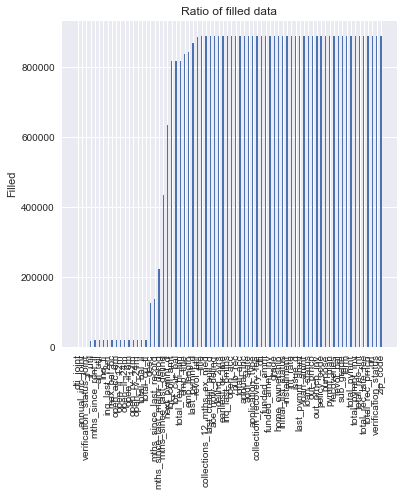

In [29]:
# Check how much of the columns in data is filled
# PLot ratio of filled values in columns
filled, filled_x = Data_plot_filled("filled_1")
filled_proc = [(filled[i]/data_nrows) for i in range(0, len(filled))]
# *Note* This may not be well visible for larger amount of columns. Still it could give us some information

In [ ]:
# Those lines below are used for getting to know with data
# At the final stage I see no reason for showing that amount of plots
# I will guide you step-by-step through the data in next chapter, suppress them now

In [28]:
# Plot histogram for every numerical column with respect to loan_status value
#plot_target_hist_num()

In [29]:
# Plot numericals variable distribution for few different bins configuration
#plot_proba_hist_num()

In [30]:
# Plot histograms and probability distribution of defaulting fo every categorical column 
#plot_proba_hist_obj()

## 4. Cleanup and Transform the Data

Check whether title and description could be meaningful

In [31]:
pd.options.mode.chained_assignment = None  # default='warn'

desc_nans  loan_status
0          0              719603
           1               41748
1          0              108957
           1               17071
Name: loan_status, dtype: int64


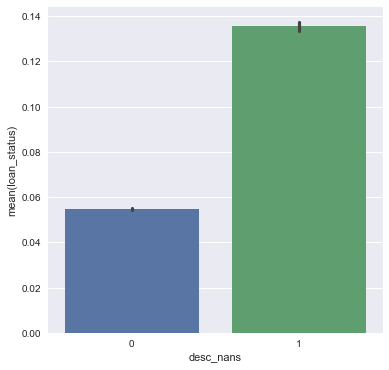

In [32]:
do_nans('desc')

title_nans  loan_status
0           0                 149
            1                   3
1           0              828411
            1               58816
Name: loan_status, dtype: int64


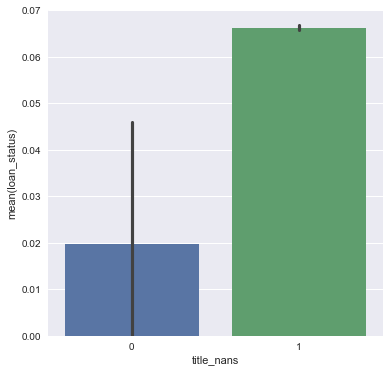

In [33]:
do_nans('title')

Quite big difference - It seems that it was collected in the way that people got loan without title or description only if they appeared to be very 'safe'

Check length and number of words in title and description

In [36]:
# Fill empty cells with meaningless string
data.desc.fillna(value='nothing', inplace=True)
data.title.fillna(value='nothing', inplace=True)

# Engineer new features: length and word count based on title and description
tit_len = data["title"].apply(lambda x: len(x))
tit_words = data["title"].apply(lambda x: x.count(' '))
data['tit_len'] = tit_len
data['tit_words'] = tit_words

desc_len = data["desc"].apply(lambda x: len(x))
desc_words = data["desc"].apply(lambda x: x.count(' '))
data['desc_len'] = desc_len
data['desc_words'] = desc_words

In [37]:
sum(data['desc']=='nothing')

761351

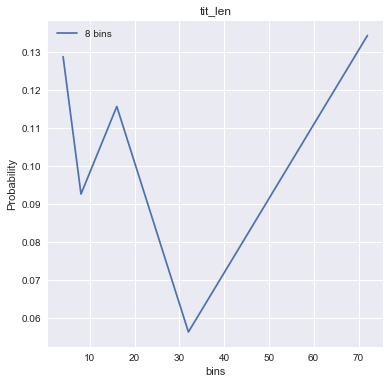

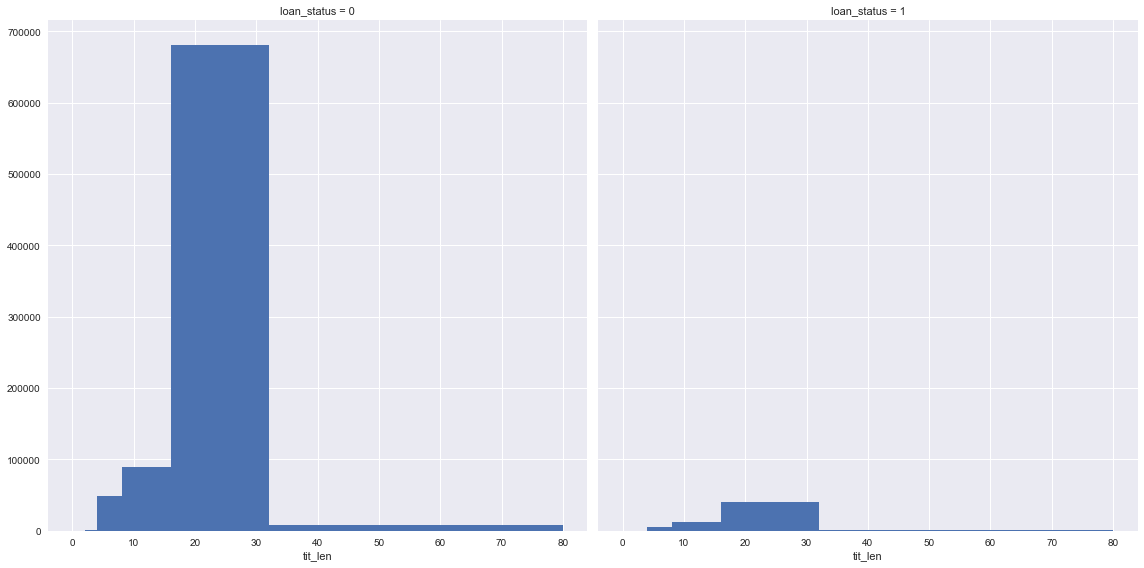

In [39]:
# Show results for a Title
plot_me_proba("tit_len",0,[0,1,2,4,8,16,32,max(data['tit_len'] )])

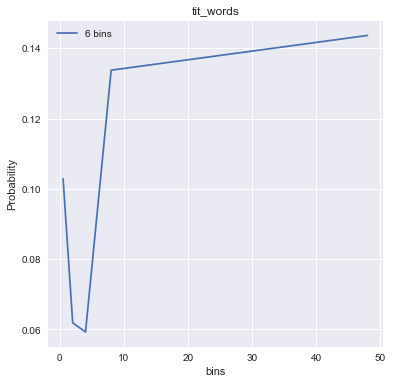

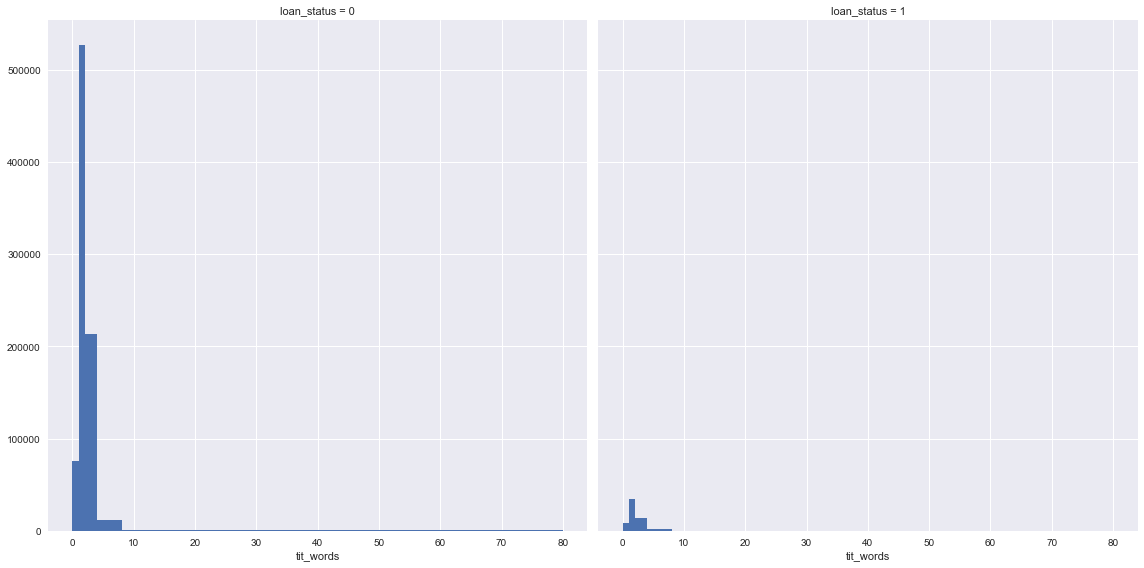

In [40]:
plot_me_proba("tit_words",0,[0,1,2,4,8,max(data['tit_len'] )])

If there is any trend there, it must be seen in 'purpose'

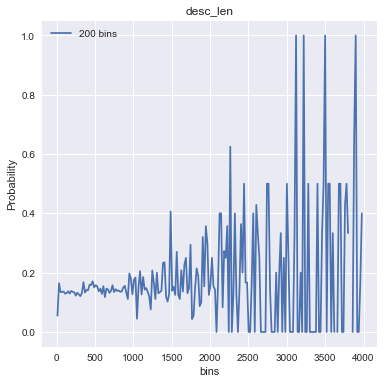

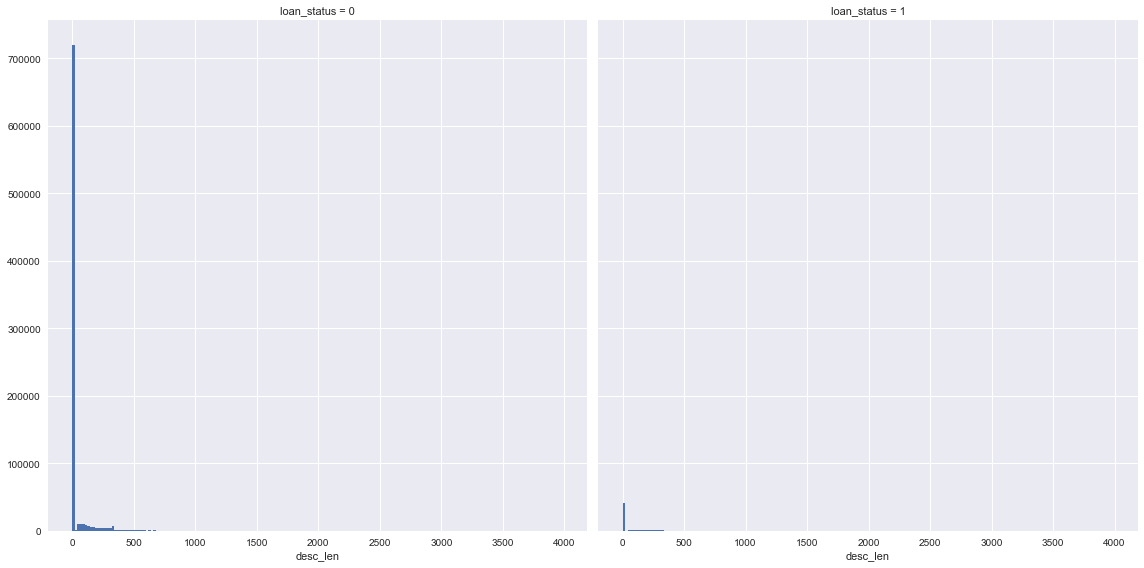

In [41]:
# Show results for Description
plot_me_proba("desc_len",200)

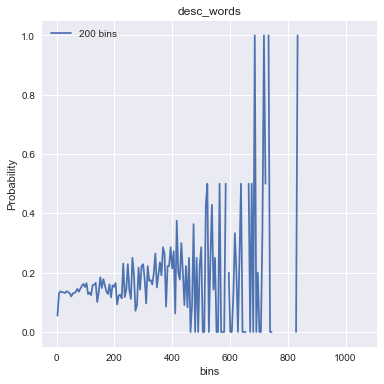

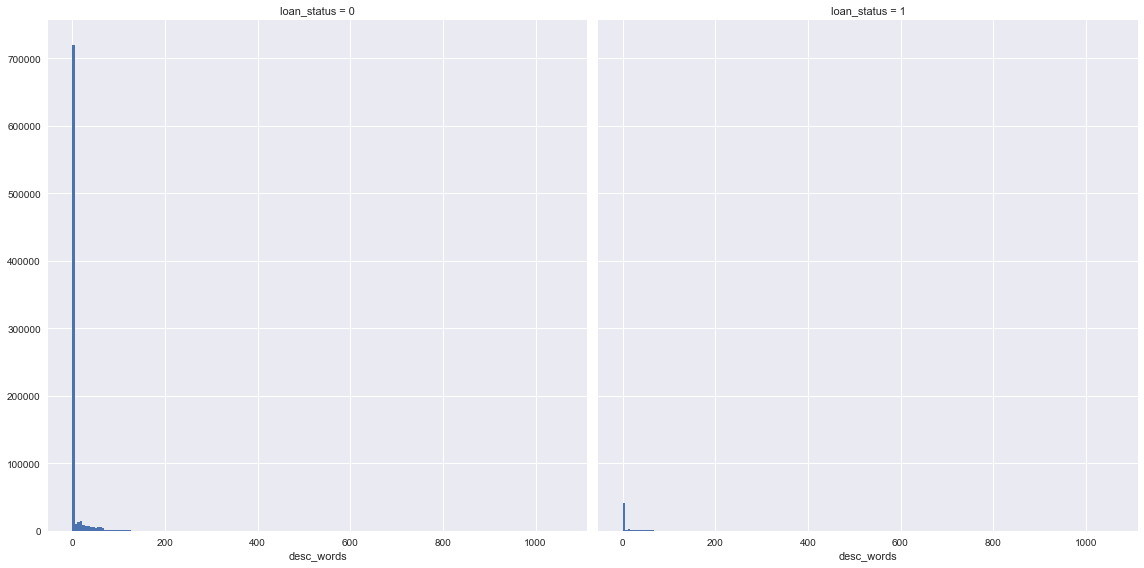

In [42]:
plot_me_proba("desc_words",200,[0,2,4,6,7,8,10,15,28,max(data.desc_len)])

In [34]:
# one can look for some tags in this strings, I'll not do that
# We can drop: title, desc, desc_words, desc_len, title_words, title_len
# Only NaNs here are meaningful

data.drop(['title', 'desc', 'desc_words', 'desc_len', 'tit_words', 'tit_len'], axis=1, inplace=True)
#data.drop(['title', 'desc'], axis=1, inplace=True)


In [35]:
data.head()

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0     5000.0       5000.0           4975.0   36 months     10.65       162.87   
1     2500.0       2500.0           2500.0   60 months     15.27        59.83   
2     2400.0       2400.0           2400.0   36 months     15.96        84.33   
3    10000.0      10000.0          10000.0   36 months     13.49       339.31   
4     3000.0       3000.0           3000.0   60 months     12.69        67.79   

  grade sub_grade                 emp_title emp_length home_ownership  \
0     B        B2                       NaN  10+ years           RENT   
1     C        C4                     Ryder   < 1 year           RENT   
2     C        C5                       NaN  10+ years           RENT   
3     C        C1       AIR RESOURCES BOARD  10+ years           RENT   
4     B        B5  University Medical Group     1 year           RENT   

   annual_inc verification_status   issue_d  loan_status pymnt_plan  \
0     24000.0            Verified  Dec-2011            0          n   
1     30000.0     Source Verified  Dec-2011            1          n   
2     12252.0        Not Verified  Dec-2011            0          n   
3     49200.0     Source Verified  Dec-2011            0          n   
4     80000.0     Source Verified  Dec-2011            0          n   

                                                 url         purpose zip_code  \
0  https://www.lendingclub.com/browse/loanDetail....     credit_card    860xx   
1  https://www.lendingclub.com/browse/loanDetail....             car    309xx   
2  https://www.lendingclub.com/browse/loanDetail....  small_business    606xx   
3  https://www.lendingclub.com/browse/loanDetail....           other    917xx   
4  https://www.lendingclub.com/browse/loanDetail....           other    972xx   

  addr_state    dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0         AZ  27.65          0.0         Jan-1985             1.0   
1         GA   1.00          0.0         Apr-1999             5.0   
2         IL   8.72          0.0         Nov-2001             2.0   
3         CA  20.00          0.0         Feb-1996             1.0   
4         OR  17.94          0.0         Jan-1996             0.0   

   mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  \
0                     NaN                     NaN       3.0      0.0   
1                     NaN                     NaN       3.0      0.0   
2                     NaN                     NaN       2.0      0.0   
3                    35.0                     NaN      10.0      0.0   
4                    38.0                     NaN      15.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0    13648.0        83.7        9.0                   f        0.0   
1     1687.0         9.4        4.0                   f        0.0   
2     2956.0        98.5       10.0                   f        0.0   
3     5598.0        21.0       37.0                   f        0.0   
4    27783.0        53.9       38.0                   f      766.9   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0            0.0   5861.071414          5831.78          5000.00   
1            0.0   1008.710000          1008.71           456.46   
2            0.0   3003.653644          3003.65          2400.00   
3            0.0  12226.302212         12226.30         10000.00   
4          766.9   3242.170000          3242.17          2233.10   

   total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  \
0         861.07                0.00        0.00                     0.00   
1         435.17                0.00      117.08                     1.11   
2         603.65                0.00        0.00                     0.00   
3        2209.33               16.97        0.00                     0.00   
4        1009.07                0.00        0.00                     0.00   

  last_pymnt_d  last_p

In [36]:
# peek random url
data.url[241]

'https://www.lendingclub.com/browse/loanDetail.action?loan_id=1066471'

In [37]:
# There is garbage in urls, drop them
data.drop( ["url"] , axis=1, inplace=True)

### Others columns could be somehow used. Let's see trends among them

In [38]:
# Just check if there isare columns with negative minimum
for column in descNum:
    if (descNum[column][3] < 0):
        print (column, " min: ",descNum[column][3])

inq_last_12m  min:  -4.0


We need to see some probability of defaulting for every bin

## 4.0 Date time
Date will be converted to year, month, and ordinal number using funtion 'do_date()'

In [39]:
import string
import re
# Call function for date-handling
date_columns = ['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d']  # column with date type
do_date(date_columns)
for columns in date_columns:
    tmp_unix = list(data[columns].unique())
    tmp_unix.sort()
    tmp_unix_rep2 = [i for i in range(0, len(tmp_unix))]
    data[columns].replace(tmp_unix,tmp_unix_rep2, inplace=True)

issue_d
earliest_cr_line
last_pymnt_d
next_pymnt_d
last_credit_pull_d


Now with few more variables we have everything under control regarding date-type

# 

# 4.1 Numericals Feature  Engineering
In this important part I will perform hypothesis testing to reveal hidden patterns in data that could further be used by classifation model.
Analyzing numerical variable is divided into steps:
- creating new feature that mark 'NaNs' in the column. Name with '_nan' suffix
- filling 'NaN' with chosen value
- plotting data with proposed bin categories
- creating new variable for binned data. Name with '_nan' suffix

I have came up with few novel features based on dividing, subtracting or comparison, between variables.
Unfortunately steps taken to achieve good engineered feature can't be easily summed up here, so please go to the points:



In [40]:
# I will analyze every column in the order of original data columns
data.describe()

loan_amnt    funded_amnt  funded_amnt_inv       int_rate  \
count  887379.000000  887379.000000    887379.000000  887379.000000   
mean    14755.264605   14741.877625     14702.464383      13.246740   
std      8435.455601    8429.897657      8442.106732       4.381867   
min       500.000000     500.000000         0.000000       5.320000   
25%      8000.000000    8000.000000      8000.000000       9.990000   
50%     13000.000000   13000.000000     13000.000000      12.990000   
75%     20000.000000   20000.000000     20000.000000      16.200000   
max     35000.000000   35000.000000     35000.000000      28.990000   

         installment    annual_inc        issue_d    loan_status  \
count  887379.000000  8.873750e+05  887379.000000  887379.000000   
mean      436.717127  7.502759e+04      85.284540       0.066284   
std       244.186593  6.469830e+04      15.386312       0.248778   
min        15.670000  0.000000e+00       0.000000       0.000000   
25%       260.705000  4.500000e+04      78.000000       0.000000   
50%       382.550000  6.500000e+04      89.000000       0.000000   
75%       572.600000  9.000000e+04      97.000000       0.000000   
max      1445.460000  9.500000e+06     102.000000       1.000000   

                 dti    delinq_2yrs  earliest_cr_line  inq_last_6mths  \
count  887379.000000  887350.000000     887379.000000   887350.000000   
mean       18.157039       0.314442        521.144385        0.694623   
std        17.190626       0.862244         89.272088        0.998448   
min         0.000000       0.000000          0.000000        0.000000   
25%        11.910000       0.000000        476.000000        0.000000   
50%        17.650000       0.000000        539.000000        0.000000   
75%        23.950000       0.000000        583.000000        1.000000   
max      9999.000000      39.000000        697.000000       33.000000   

       mths_since_last_delinq  mths_since_last_record       open_acc  \
count           433067.000000           137053.000000  887350.000000   
mean                34.063798               70.117903      11.548469   
std                 21.884940               28.127914       5.317313   
min                  0.000000                0.000000       0.000000   
25%                 15.000000               51.000000       8.000000   
50%                 31.000000               70.000000      11.000000   
75%                 50.000000               92.000000      14.000000   
max                188.000000              129.000000      90.000000   

             pub_rec     revol_bal     revol_util      total_acc  \
count  887350.000000  8.873790e+05  886877.000000  887350.000000   
mean        0.195307  1.692079e+04      55.067693      25.268026   
std         0.582091  2.242679e+04      23.834344      11.840561   
min         0.000000  0.000000e+00       0.000000       1.000000   
25%         0.000000  6.443000e+03      37.700000      17.000000   
50%         0.000000  1.187500e+04      56.000000      24.000000   
75%         0.000000  2.082900e+04      73.600000      32.000000   
max        86.000000  2.904836e+06     892.300000     169.000000   

           out_prncp  out_prncp_inv    total_pymnt  total_pymnt_inv  \
count  887379.000000  887379.000000  887379.000000    887379.000000   
mean     8403.124852    8399.713242    7558.826684      7521.160306   
std      8493.450269    8489.997617    7871.243336      7846.108604   
min         0.000000       0.000000       0.000000         0.000000   
25%         0.000000       0.000000    1914.590000      1899.700000   
50%      6458.290000    6455.810000    4894.999117      4862.010000   
75%     13659.055000   13654.050000   10616.814231     10565.690000   
max     49372.860000   49372.860000   57777.579870     57777.580000   

       total_rec_prncp  total_rec_int  total_rec_late_fee     recoveries  \
count    887379.000000  887379.000000       887379.000000  887379.000000   
mean       5757.706424    1754.804327         

### 4.1.1 loan_amnt
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

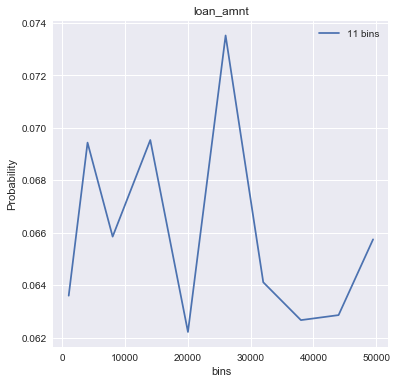

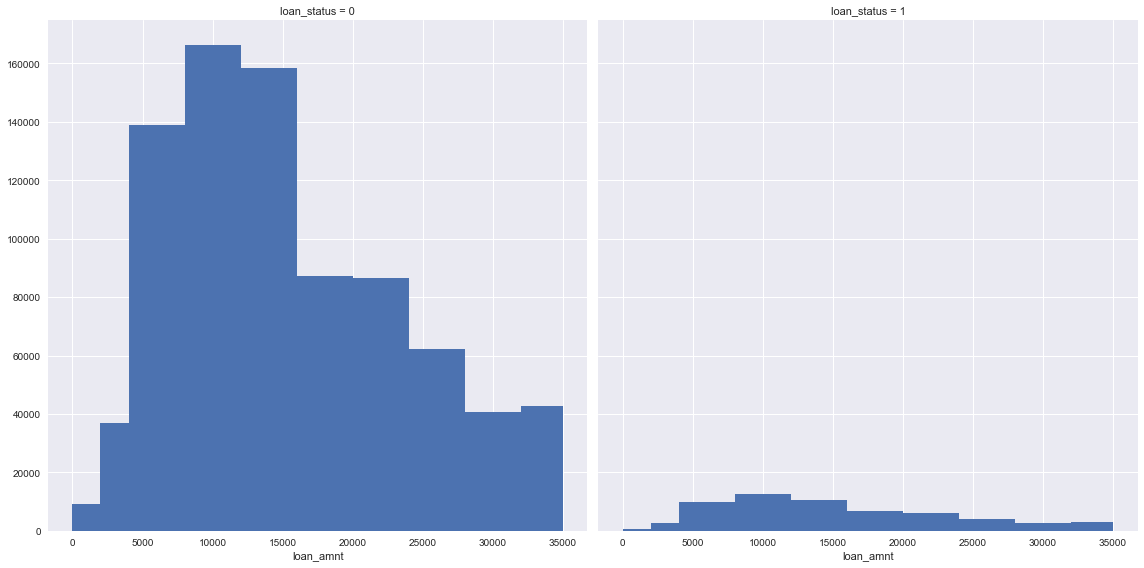

In [41]:
plot_me_proba('loan_amnt',0,[0,2000,4000,8000,12000,16000,20000,24000,28000,32000,max(data.loan_amnt)])

Now defaulting clients are uniformly distributed (please note the scale on the left)

In [42]:
bin_it_wisely('loan_amnt',[0,2000,4000,8000,12000,16000,20000,24000,28000,32000,max(data.loan_amnt)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 2000, 4000, 8000, 12000, 16000, 20000, 24000, 28000, 32000, 35000.0]


### 4.1.2  funded_amnt and funded_amnt_inv  feature engineering
funded_amnt- The total amount committed to that loan at that point in time.

funded_amnt_inv-	The total amount committed by investors for that loan at that point in time.

funded amnt and funded_amnt_inv are very similar to loan_amnt, so I'll transform them into binary feature

In [43]:
# Now, there is a lot of similar columns, that should be checked in case of redundancy

# I'm wondering why: "at some point in time, the credit department could reduce the loan amount"
# But- it will be reflected in this value.  [LCDescription]

# Instead of deleting them - let's engineer them!

# The observed hierarchy is as follows: loan_amnt >= funded_amnt >= funded_amnt_inv  
# where it is more common to see '>' in second comparison
# I'm turning it into binary column, True standing for operator '>', False for '='

data["amnt_loan_fund_gr"] = data['loan_amnt'] > data['funded_amnt']
data["amnt_fund_finv_gr"] = data['funded_amnt'] > data['funded_amnt_inv']

# I will later resign from original info: "funded_amnt" and "funded_amnt_inv", as they add some noise now
# but they will also be used for engineering others features


print("loan_amnt > funded_amnt : #", sum(data["amnt_loan_fund_gr"]))
print("funded_amnt > funded_amnt_inv :#", sum(data["amnt_fund_finv_gr"]))

loan_amnt > funded_amnt : # 2062
funded_amnt > funded_amnt_inv :# 100599


loan_status  amnt_loan_fund_gr
0            False                826878
             True                   1682
1            False                 58439
             True                    380
Name: amnt_loan_fund_gr, dtype: int64


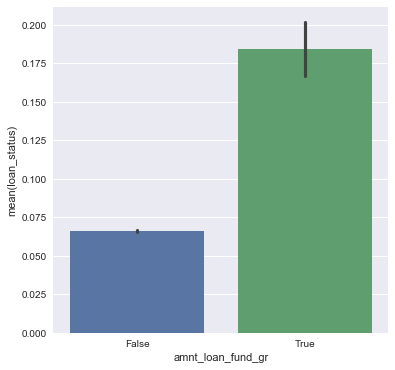

In [44]:
print (data.groupby('loan_status').amnt_loan_fund_gr.value_counts())
sns.barplot(x="amnt_loan_fund_gr", y="loan_status", data=data); 

loan_status  amnt_fund_finv_gr
0            False                737384
             True                  91176
1            False                 49396
             True                   9423
Name: amnt_fund_finv_gr, dtype: int64


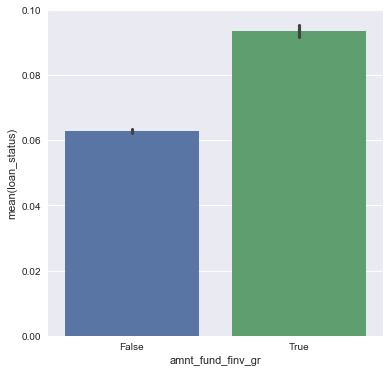

In [45]:
print (data.groupby('loan_status').amnt_fund_finv_gr.value_counts())
sns.barplot(x="amnt_fund_finv_gr", y="loan_status", data=data); 

#### Those both are very good features

### 4.1.3 int_rate
Interest Rate on the loan

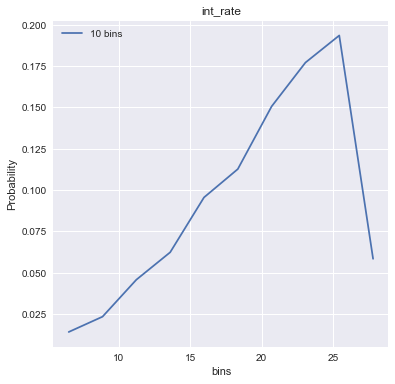

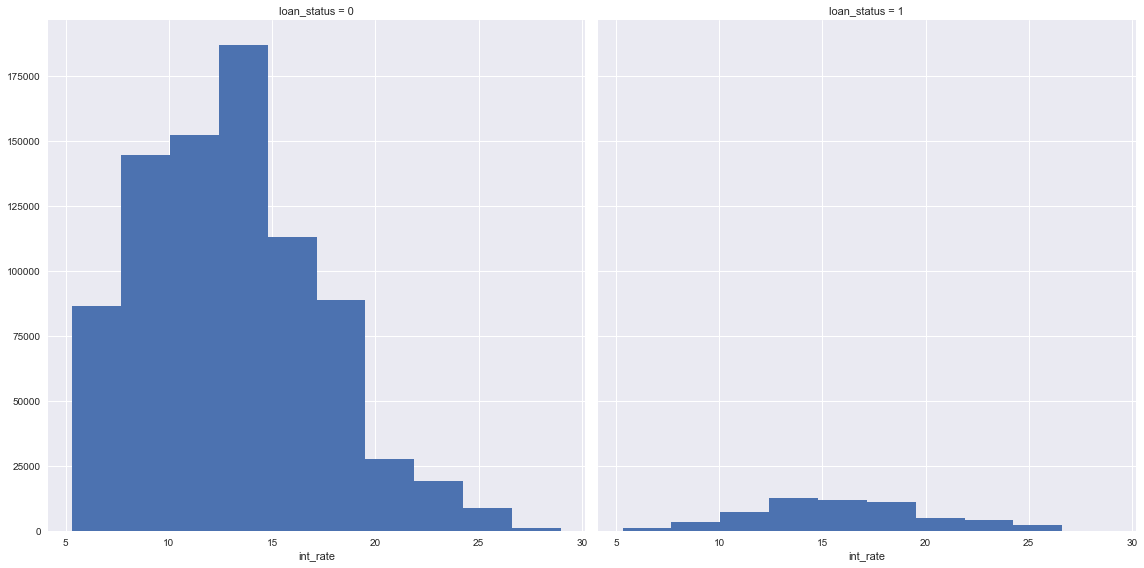

In [46]:
plot_me_proba('int_rate',10)

#### int_rate is another important trend to be used, due to it's strictly closeness to risk

In [47]:
# it could be transformed into 10 uniformly spaced bins
bin_it_wisely('int_rate', 10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
10


### 4.1.4 installment
The monthly payment owed by the borrower if the loan originates.

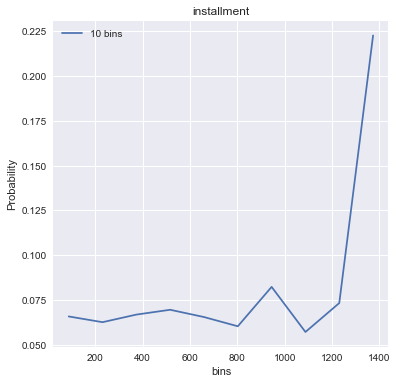

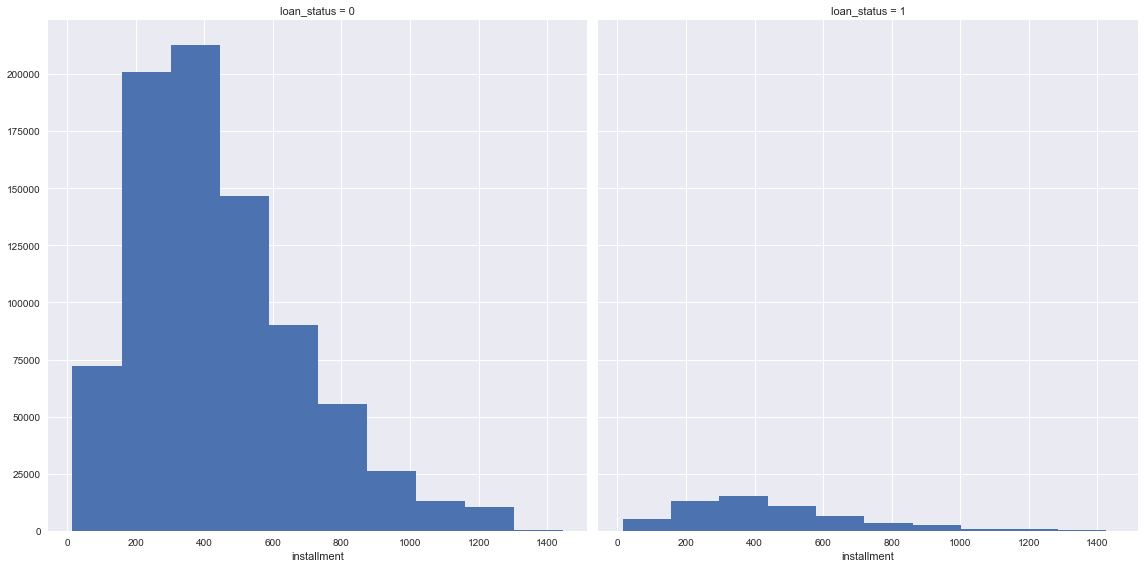

In [48]:
plot_me_proba('installment',10)

#### Installment isn't probably the most informative column, but I think it could be changed later by composing new feature based on this

In [49]:
# Now, inject those bins from plot to data
bin_it_wisely('installment',10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
10


### 4.1.5 annual_inc
The self-reported annual income provided by the borrower during registration.

annual_inc_nans  loan_status
0.0              0                   4
1.0              0              828556
                 1               58819
Name: loan_status, dtype: int64


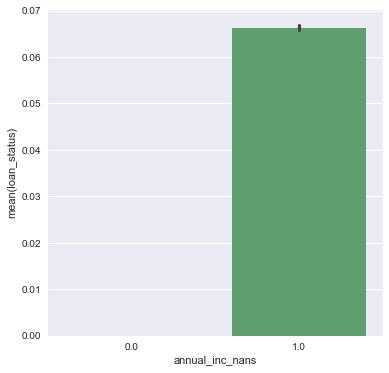

In [50]:
do_nans('annual_inc')

In [51]:
data.annual_inc.fillna(value=data["annual_inc"].median()*10, inplace=True)

In [52]:
# for people that earns above certain amount it is quite similar expenditure
data.annual_inc[data.annual_inc >= 200000] = 200000                

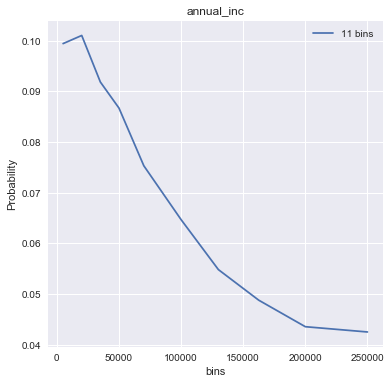

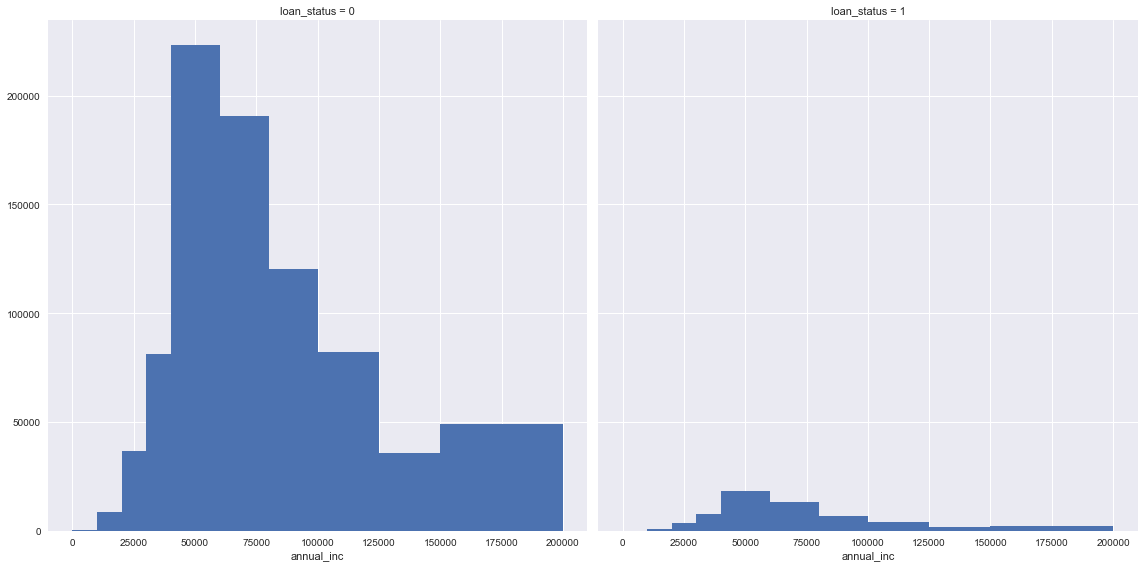

In [53]:
plot_me_proba('annual_inc',0,[0,10000,20000,30000,40000,60000,80000,100000,125000,150000,200000])

#### No suprise that trend is strong

In [54]:
bin_it_wisely('annual_inc',[0,10000,20000,30000,40000,60000,80000,100000,125000,150000,200000])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 10000, 20000, 30000, 40000, 60000, 80000, 100000, 125000, 150000, 200000]


### 4.1.6 dti 
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.


In [55]:
# again, DTI is the ratio taking into account monthly payments and earnings
print(sum(data.dti> 40))
data.dti[data.dti >= 40] = 40      

90


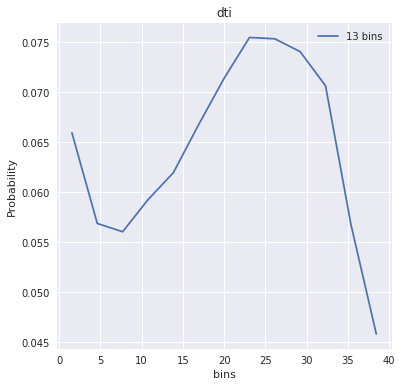

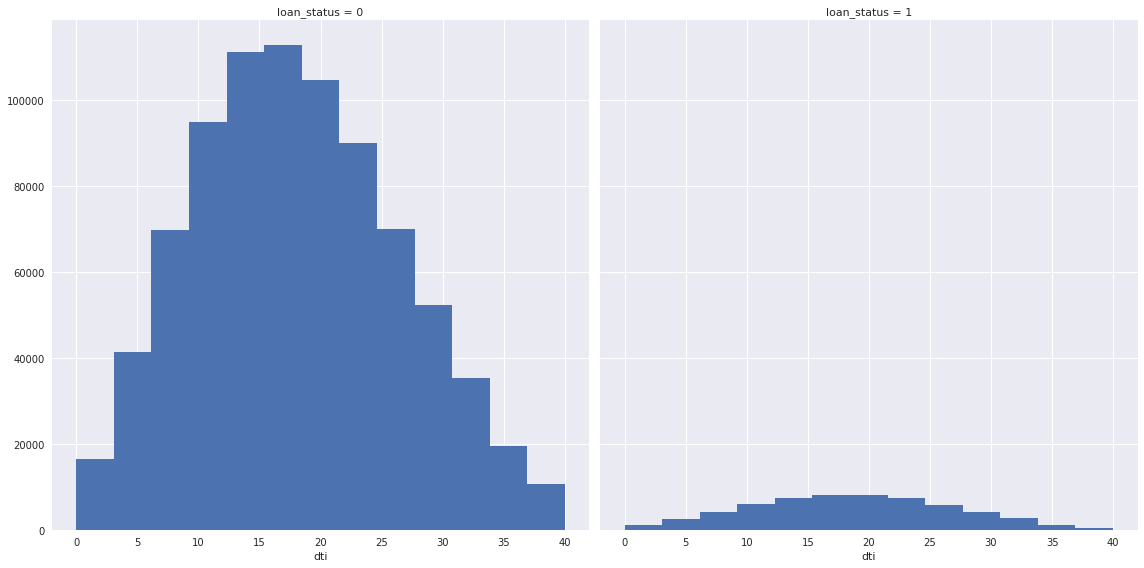

In [52]:
plot_me_proba('dti',13)

In [56]:
bin_it_wisely('dti',13)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
13


### 4.1.7 delinq_2yrs
The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

delinq_2yrs_nans  loan_status
0.0               0                  26
                  1                   3
1.0               0              828534
                  1               58816
Name: loan_status, dtype: int64


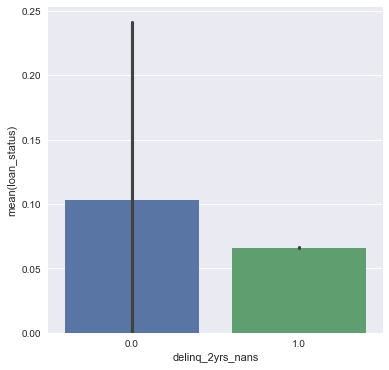

In [57]:
do_nans('delinq_2yrs')

In [58]:
data.delinq_2yrs.fillna(value=data["delinq_2yrs"].mean()*10, inplace=True)

In [59]:
print(sum(data.delinq_2yrs> 5))
data.delinq_2yrs[data.delinq_2yrs >= 5] = 5

3599


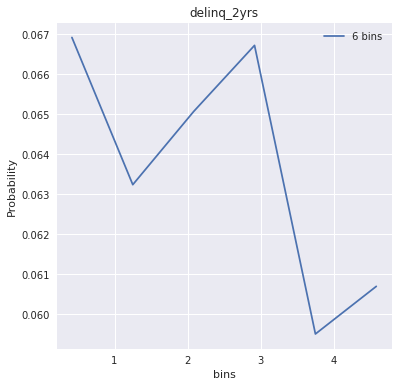

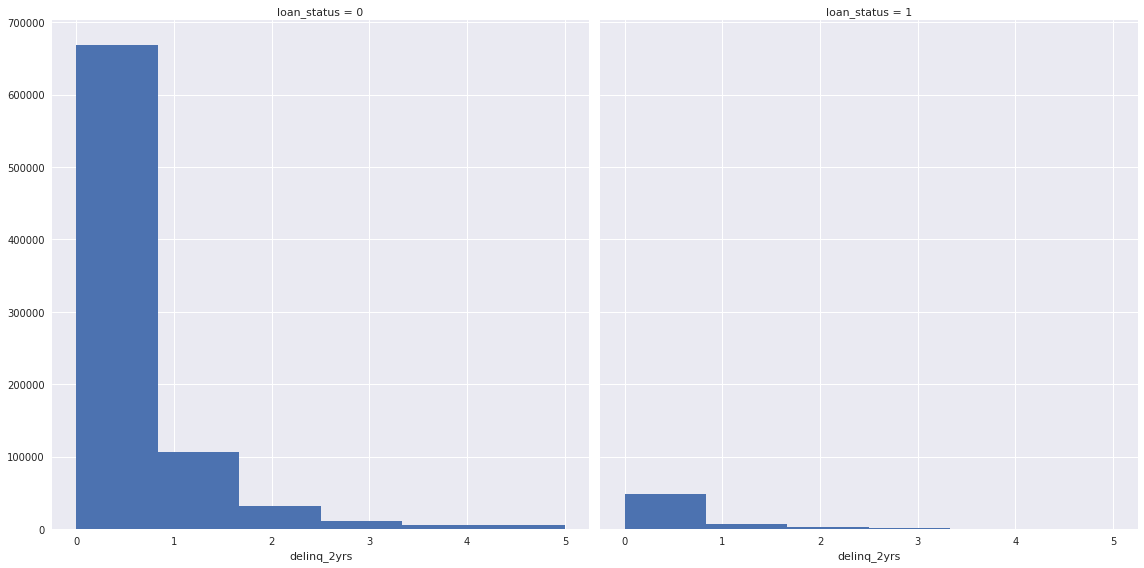

In [57]:
plot_me_proba('delinq_2yrs',6)

####  probablity is very uniformly distributed, while total count is unbalanced - drop it


In [60]:
data.drop( ["delinq_2yrs"] , axis=1, inplace=True)
# drop nans
data.drop( ["delinq_2yrs_nans"] , axis=1, inplace=True)

### 4.1.8 inq_last_6mths
The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

inq_last_6mths_nans  loan_status
0.0                  0                  26
                     1                   3
1.0                  0              828534
                     1               58816
Name: loan_status, dtype: int64


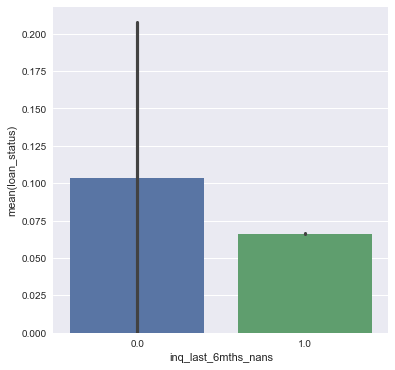

In [61]:
do_nans('inq_last_6mths')

In [62]:
data['inq_last_6mths'] = data['inq_last_6mths']
data.inq_last_6mths.fillna(value=data["inq_last_6mths"].mean()*10, inplace=True)
print(sum(data.inq_last_6mths > 5))
data.inq_last_6mths[data.inq_last_6mths >= 5] = 5

1722


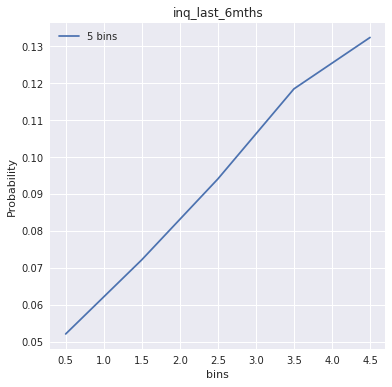

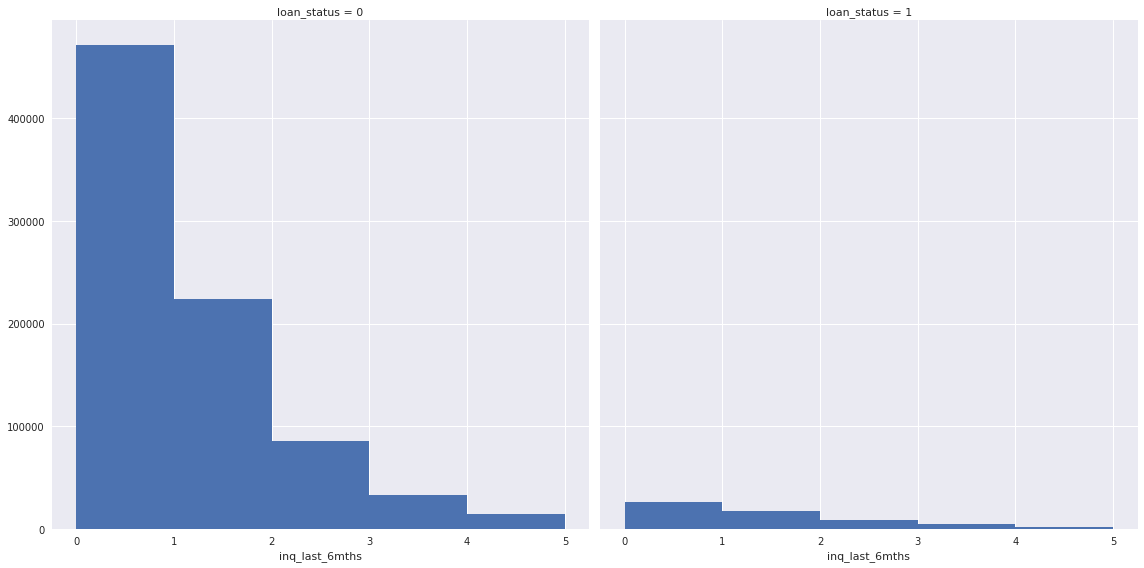

In [61]:
plot_me_proba('inq_last_6mths',5)

#### There is a visible significant trend

In [63]:
bin_it_wisely('inq_last_6mths',5)

[0, 1, 2, 3, 4]
5


In [64]:
data.drop( ["inq_last_6mths_nans"] , axis=1, inplace=True)

### 4.1.9 mths_since_last_delinq
The number of months since the borrower's last delinquency.

mths_since_last_delinq_nans  loan_status
0.0                          0              422816
                             1               31496
1.0                          0              405744
                             1               27323
Name: loan_status, dtype: int64


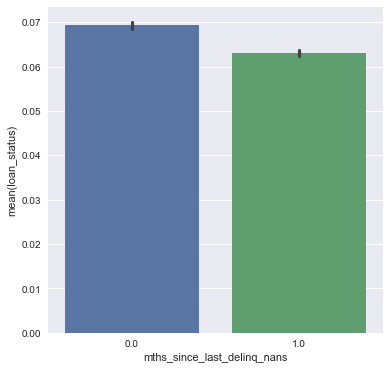

In [65]:
do_nans('mths_since_last_delinq')

In [66]:
print(sum(data.mths_since_last_delinq> 80))
data.mths_since_last_delinq[data.mths_since_last_delinq >= 80] = 80    

4108


In [67]:
data.mths_since_last_delinq.fillna(value=data["mths_since_last_delinq"].mean(), inplace=True)

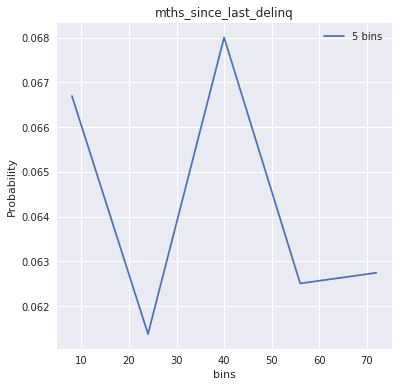

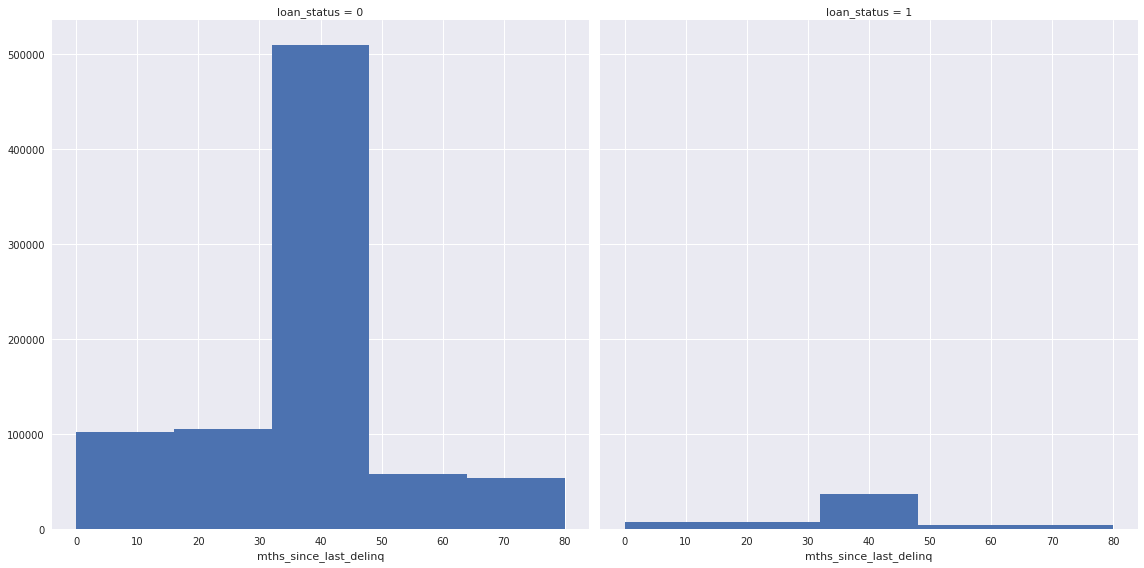

In [226]:
plot_me_proba('mths_since_last_delinq',5)

#### Insignificant

In [68]:
data.drop( ["mths_since_last_delinq"] , axis=1, inplace=True)

### 4.1.10 mths_since_last_record
The number of months since the last public record.

mths_since_last_record_nans  loan_status
0.0                          0              699631
                             1               50695
1.0                          0              128929
                             1                8124
Name: loan_status, dtype: int64


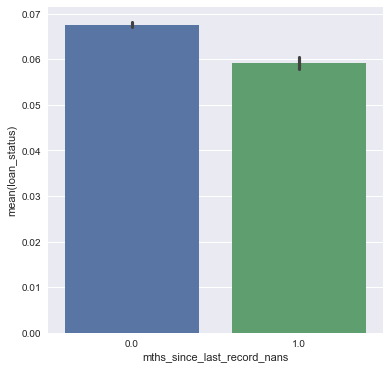

In [69]:
do_nans('mths_since_last_record')

In [70]:
data.mths_since_last_record.fillna(value=data["mths_since_last_record"].mean(), inplace=True)

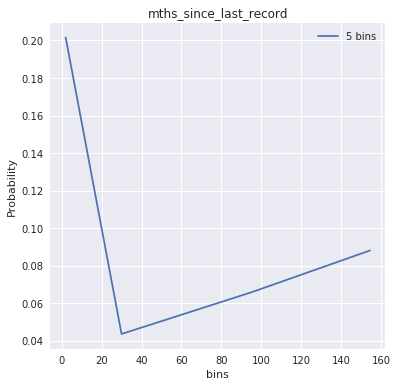

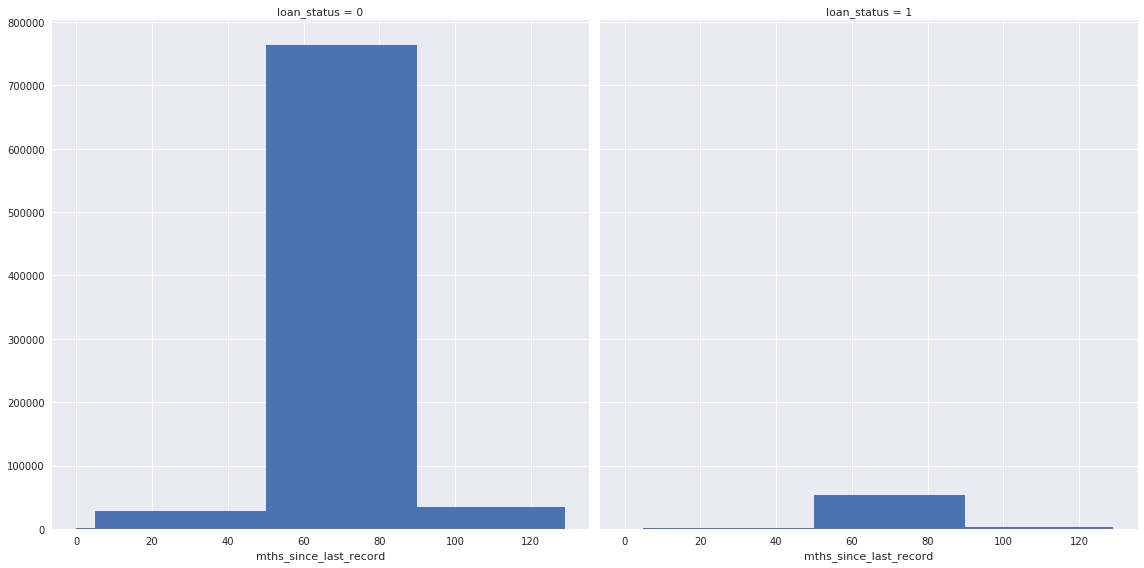

In [236]:
plot_me_proba('mths_since_last_record',0,[0,5,50,90,max(data.mths_since_last_record)])

#### There is something in this plot, leave it for the classifier to decide

In [71]:
bin_it_wisely('mths_since_last_record',[0,5,50,90,max(data.mths_since_last_record)])

[0, 1, 2, 3]
[0, 5, 50, 90, 129.0]


### 4.1.11 open_acc
The number of open credit lines in the borrower's credit file.

In [72]:
data.open_acc.fillna(value=data["open_acc"].mean(), inplace=True)

In [73]:
# nans here are not important

In [74]:
print(sum(data.open_acc> 30))
data.open_acc[data.open_acc >= 30] = 30   

5475


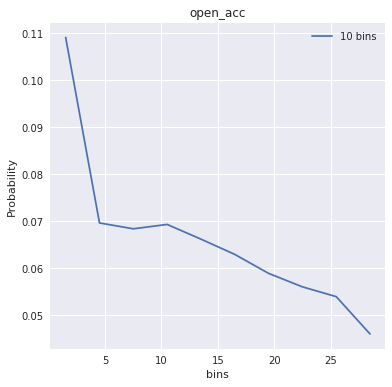

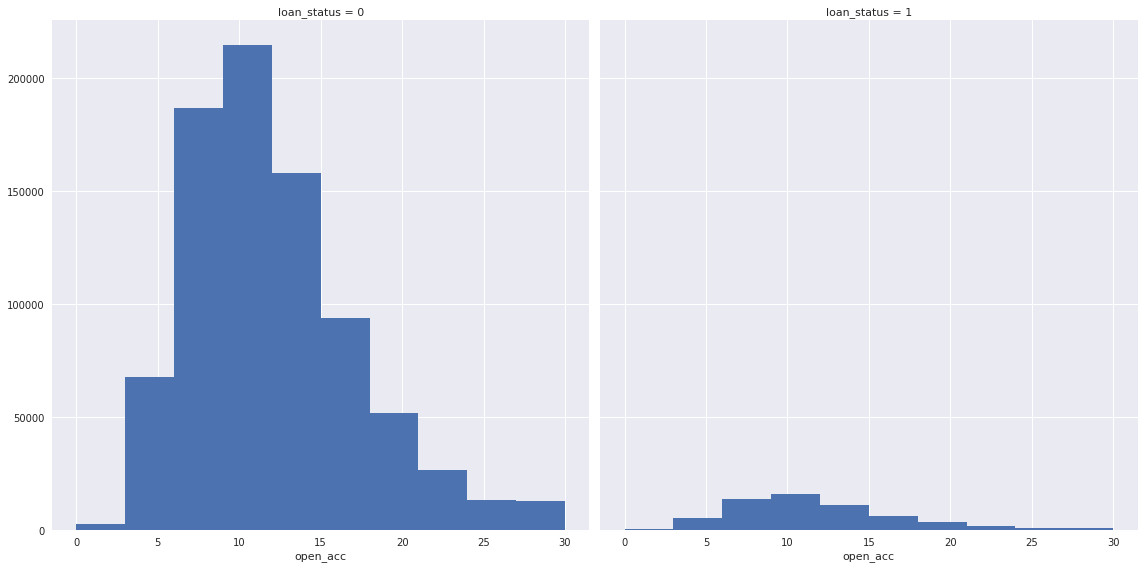

In [247]:
plot_me_proba('open_acc',10)

#### Visible trend, that could be used by models

In [75]:
bin_it_wisely('open_acc',10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
10


### 4.1.12 pub_rec
Number of derogatory public records


In [76]:
data.pub_rec.fillna(value=data["pub_rec"].mean(), inplace=True)

In [77]:
print(sum(data.pub_rec> 6))
data.pub_rec[data.pub_rec >= 6] = 6

465


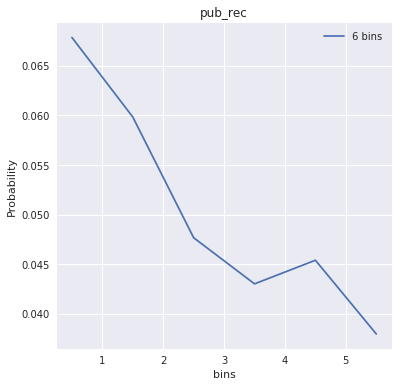

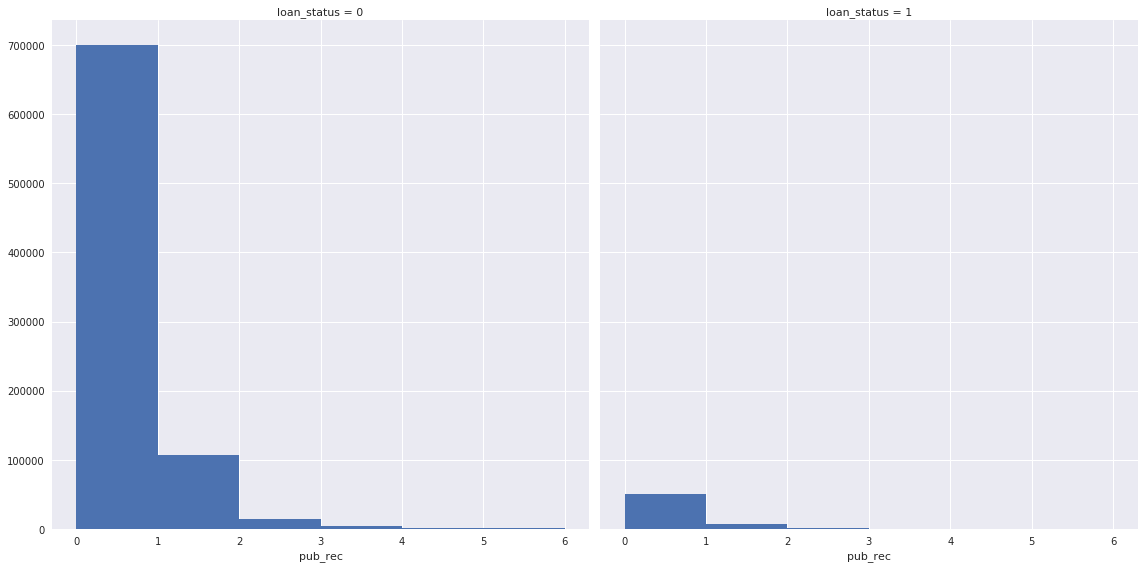

In [260]:
plot_me_proba('pub_rec',6)

#### Let them models play with it

In [78]:
bin_it_wisely('pub_rec',6)

[0, 1, 2, 3, 4, 5]
6


### 4.1.13 revol_bal
Total credit revolving balance


In [79]:
print(sum(data.revol_bal> 80000))
data.revol_bal[data.revol_bal >= 80000] = 80000

11892


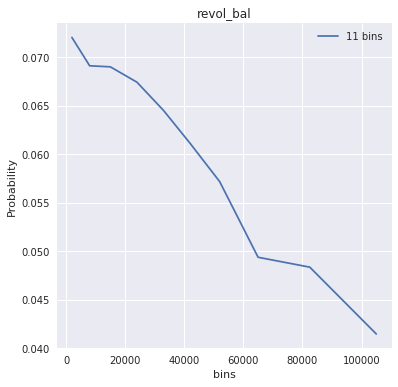

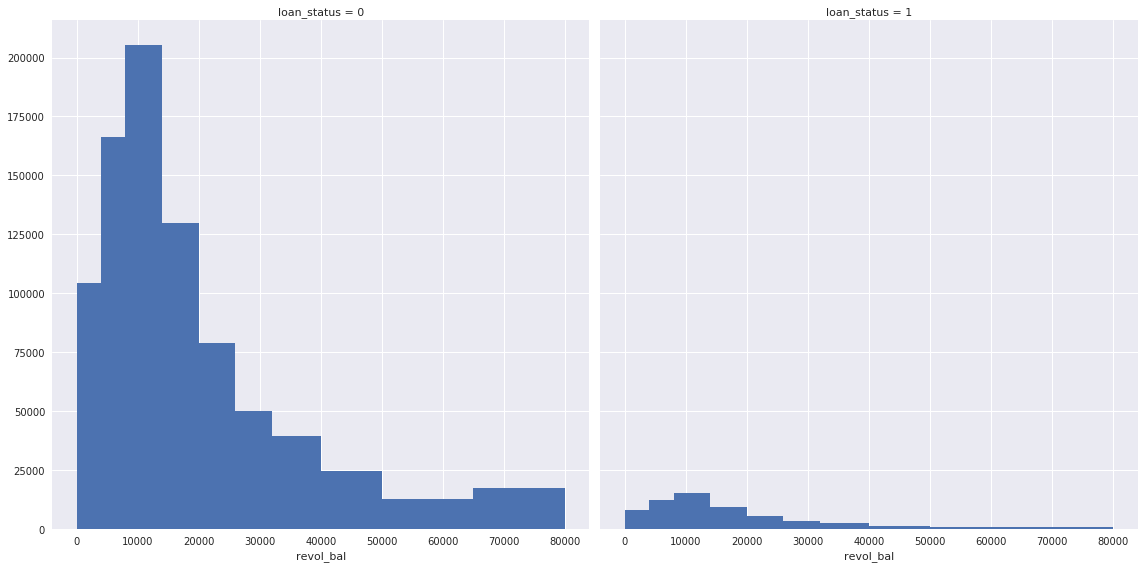

In [272]:
plot_me_proba('revol_bal',0,[0,4000,8000,14000,20000,26000,32000,40000,50000,65000,max(data.revol_bal)])

In [80]:
bin_it_wisely('revol_bal',[0,4000,8000,14000,20000,26000,32000,40000,50000,65000,max(data.revol_bal)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 4000, 8000, 14000, 20000, 26000, 32000, 40000, 50000, 65000, 80000.0]


### 4.1.14 revol_bal
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


revol_util_nans  loan_status
0.0              0                 439
                 1                  63
1.0              0              828121
                 1               58756
Name: loan_status, dtype: int64


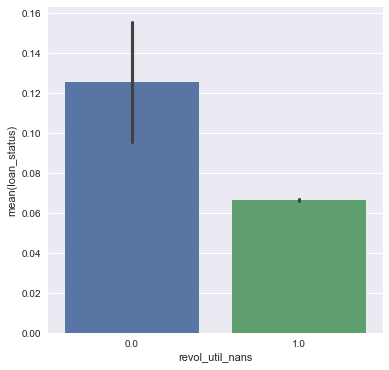

In [81]:
do_nans('revol_util')

In [82]:
data.revol_util.fillna(value=data["revol_util"].mean(), inplace=True)

In [83]:
print(sum(data.revol_util> 100))
data.revol_util[data.revol_util >= 100] = 100      

3506


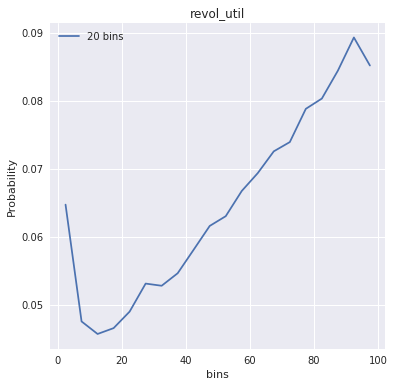

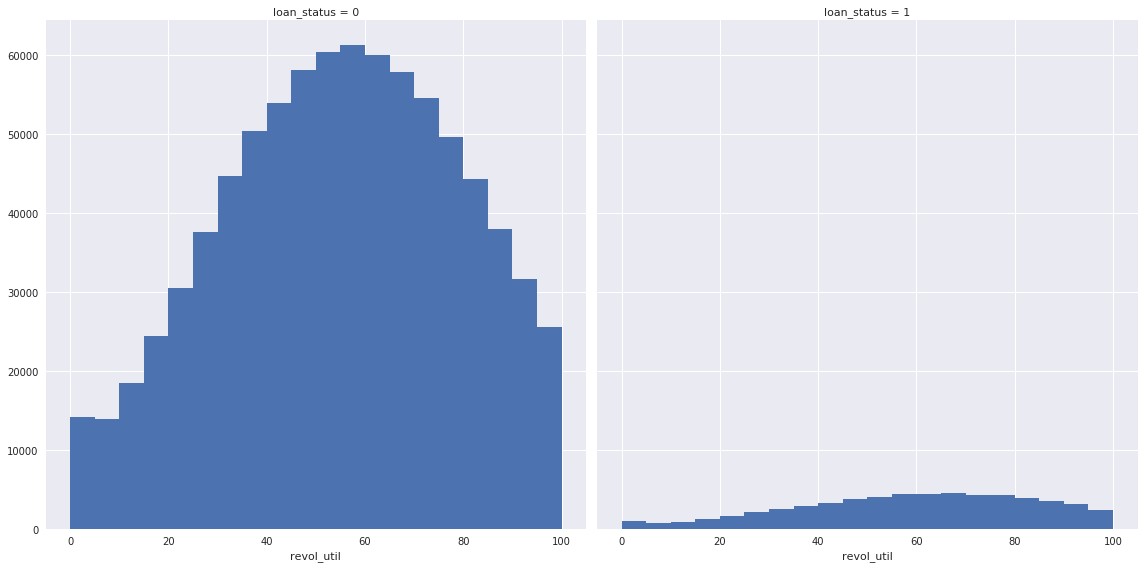

In [276]:
plot_me_proba('revol_util')

#### Bin this column 

In [84]:
bin_it_wisely('revol_util',20)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
20


### 4.1.15 total_acc
The total number of credit lines currently in the borrower's credit file

In [85]:
data.total_acc.fillna(value=data["total_acc"].mean(), inplace=True)

In [86]:
print(sum(data.total_acc > 50))
data.total_acc[data.total_acc >= 50] = 50      

29677


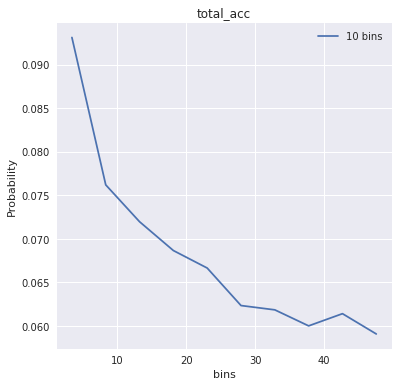

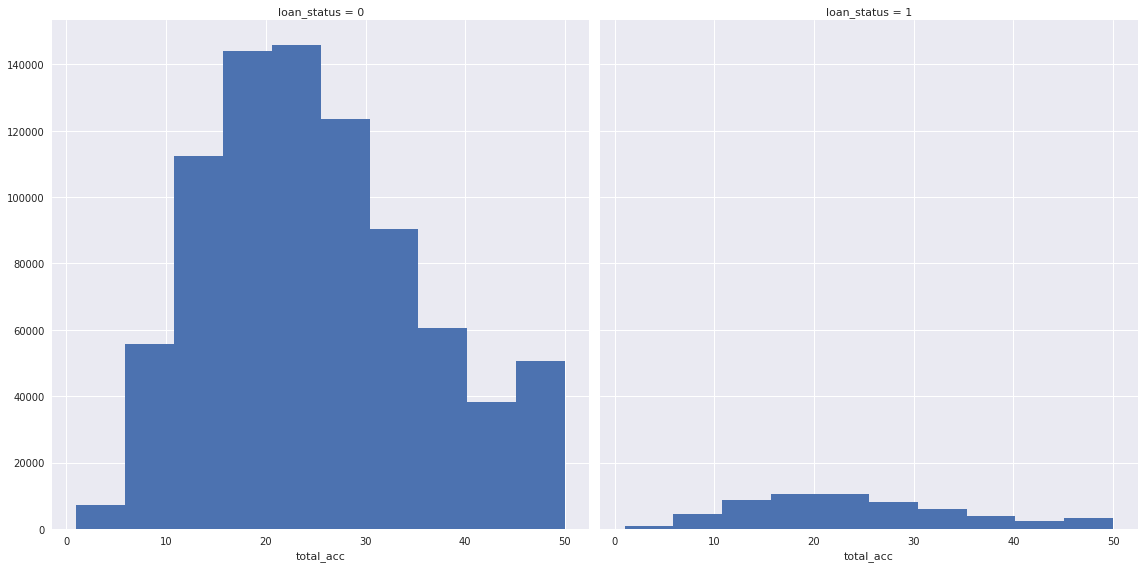

In [290]:
plot_me_proba('total_acc',10)

In [87]:
bin_it_wisely('total_acc',10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
10


### 4.1.16 out_prncp - new features based on this variable
Remaining outstanding principal for total amount funded

In [88]:
print(sum(data.out_prncp > 30000))
data.out_prncp[data.out_prncp >= 30000] = 30000

17852


In [89]:
sum(data.out_prncp==0)
data['out_prncp_zero'] = (data.out_prncp==0)

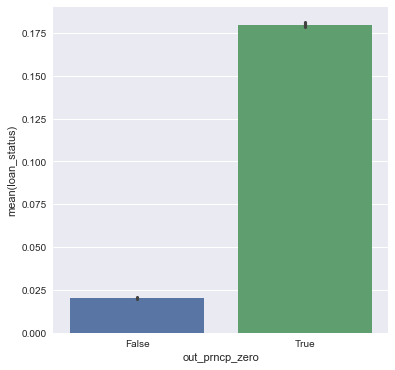

In [90]:
sns.barplot(x="out_prncp_zero", y="loan_status", data=data); 

In [91]:
data["out_prncp_inv_gr"] = data['out_prncp'] > data['out_prncp_inv']
data["out_prncp_inv_le"] = data['out_prncp'] < data['out_prncp_inv']

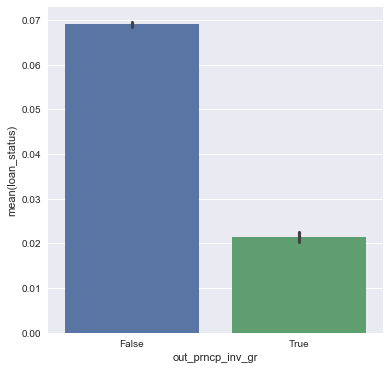

In [88]:
sns.barplot(x="out_prncp_inv_gr", y="loan_status", data=data); 

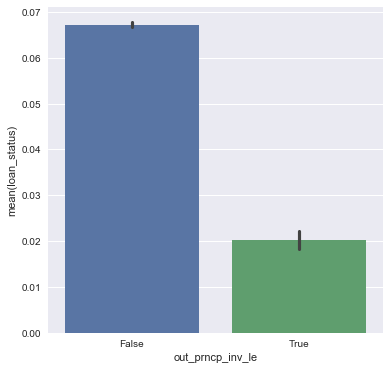

In [89]:
sns.barplot(x="out_prncp_inv_le", y="loan_status", data=data); 

### 4.1.17 total_pymnt
Payments received to date for total amount funded

In [92]:
print(sum(data.total_pymnt> 30000))
data.total_pymnt[data.total_pymnt >= 30000] = 30000

21034


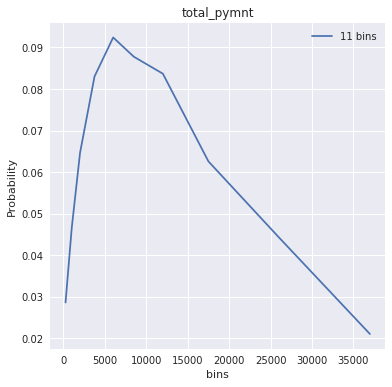

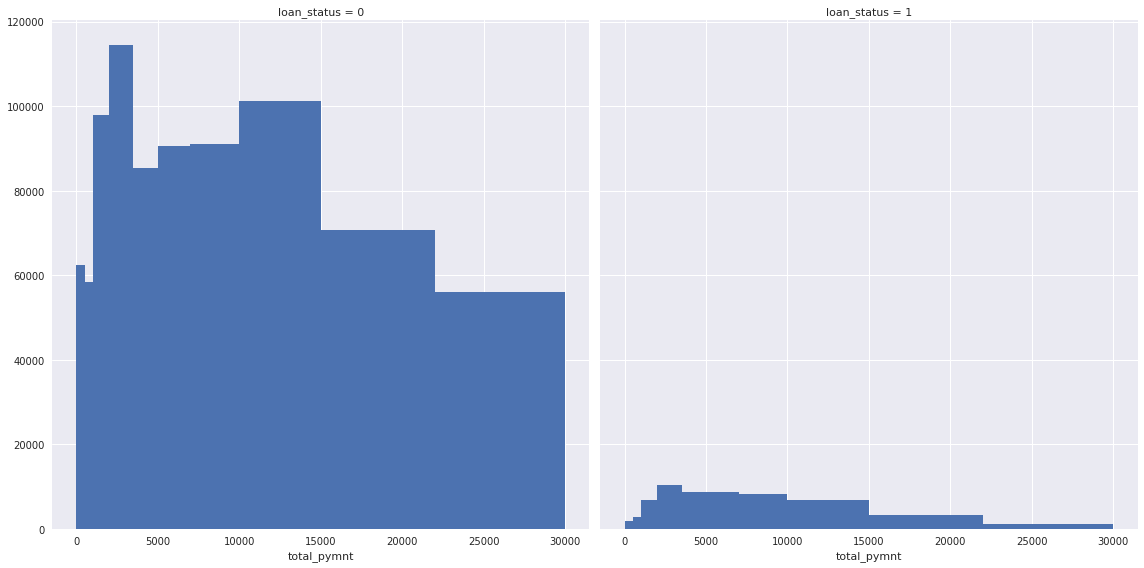

In [320]:
plot_me_proba('total_pymnt',0,[0,500,1000,2000,3500,5000,7000,10000,15000,22000,30000])

#### very interesting curvature

In [93]:
#data["total_pymnt_ch"] = data["total_pymnt"]
bin_it_wisely('total_pymnt',[0,500,1000,2000,3500,5000,7000,10000,15000,22000,30000])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 500, 1000, 2000, 3500, 5000, 7000, 10000, 15000, 22000, 30000]


### 4.1.18 total_pymnt_inv - comparison with total_pymnt
Payments received to date for portion of total amount funded by investors

In [94]:
data["total_pymnt_inv_gr"] = data['total_pymnt'] > data['total_pymnt_inv']
data["total_pymnt_inv_le"] = data['total_pymnt'] < data['total_pymnt_inv']

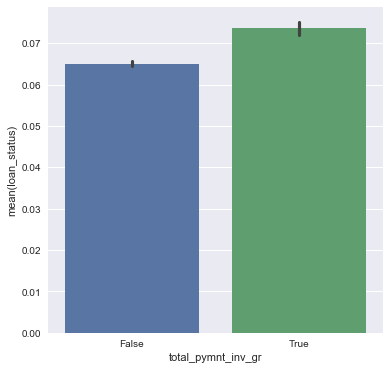

In [102]:
sns.barplot(x="total_pymnt_inv_gr", y="loan_status", data=data); 

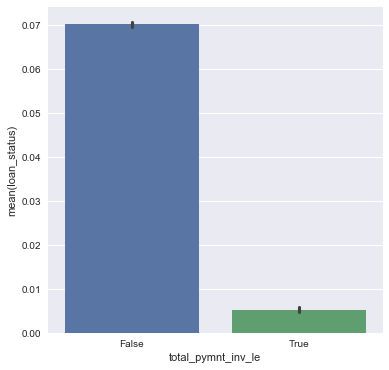

In [103]:
sns.barplot(x="total_pymnt_inv_le", y="loan_status", data=data); 

### 4.1.19 total_rec_prncp
Principal received to date

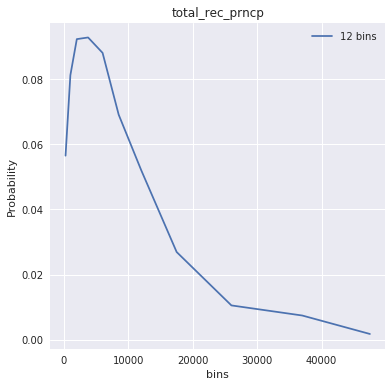

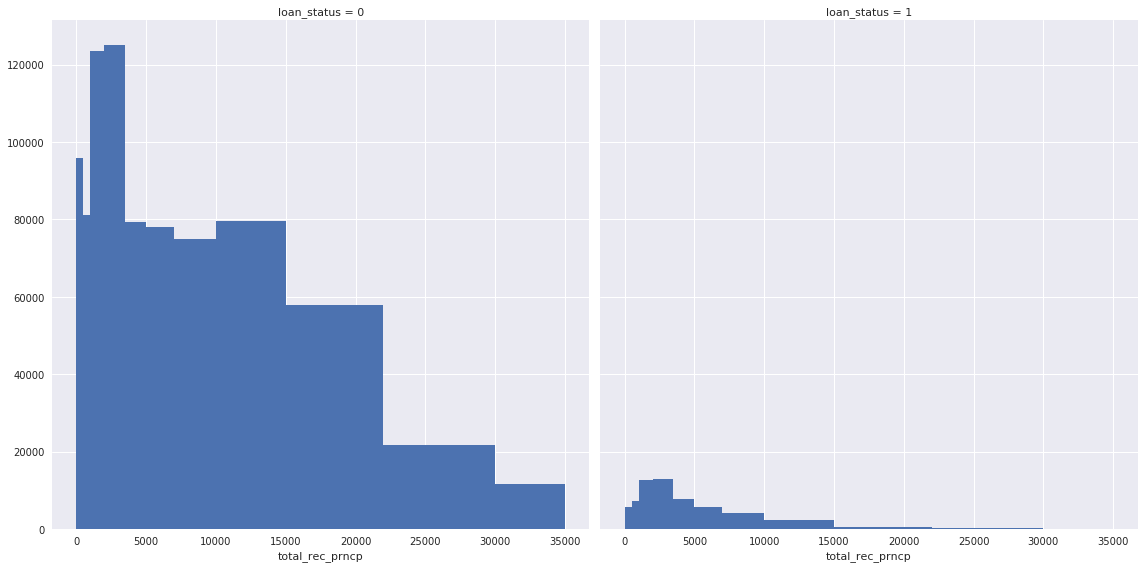

In [330]:
plot_me_proba('total_rec_prncp',0,[0,500,1000,2000,3500,5000,7000,10000,15000,22000,30000,35000])

In [95]:
bin_it_wisely('total_rec_prncp',[0,500,1000,2000,3500,5000,7000,10000,15000,22000,30000,max(data.total_rec_prncp)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 500, 1000, 2000, 3500, 5000, 7000, 10000, 15000, 22000, 30000, 35000.029999999999]


### 4.1.20 total_rec_int - comparison with total_rec_prncp
Interest received to date

In [96]:
data["total_rec_prncp_int_gr"] = data['total_rec_prncp'] > data['total_rec_int']
data["total_rec_prncp_int_le"] = data['total_rec_prncp'] < data['total_rec_int']

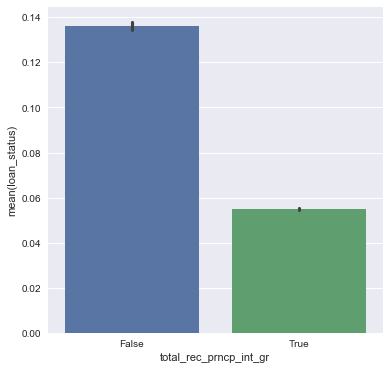

In [106]:

sns.barplot(x="total_rec_prncp_int_gr", y="loan_status", data=data); 

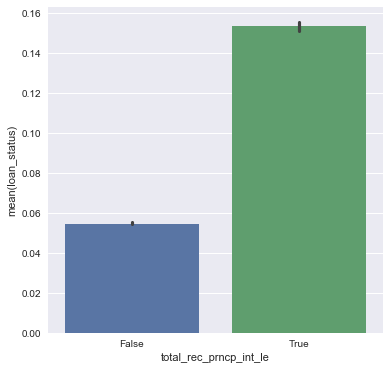

In [107]:
sns.barplot(x="total_rec_prncp_int_le", y="loan_status", data=data); 

### 4.1.21 total_rec_late_fee - comparison with total_rec_int
Late fees received to date

In [97]:
data["total_rec_late_fee_int_gr"] = data['total_rec_late_fee'] > data['total_rec_int']
data["total_rec_late_fee_int_le"] = data['total_rec_late_fee'] < data['total_rec_int']

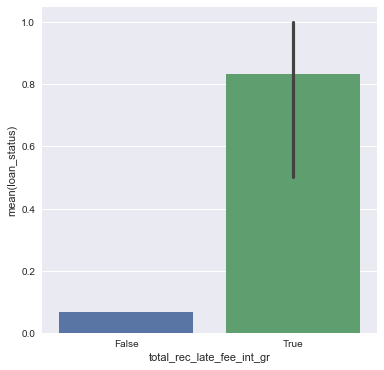

In [109]:

sns.barplot(x="total_rec_late_fee_int_gr", y="loan_status", data=data); 

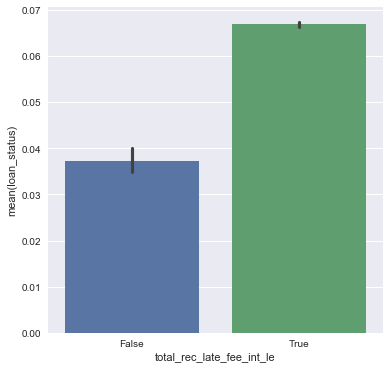

In [110]:
sns.barplot(x="total_rec_late_fee_int_le", y="loan_status", data=data); 

In [98]:
data.drop( ['total_rec_late_fee',"total_rec_prncp"] , axis=1, inplace=True)

### 4.1.22 recoveries
post charge off gross recovery


In [99]:
print(sum(data.recoveries> 10))
data.recoveries[data.recoveries >= 10] = 10

24589


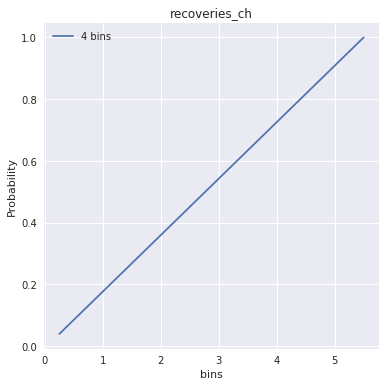

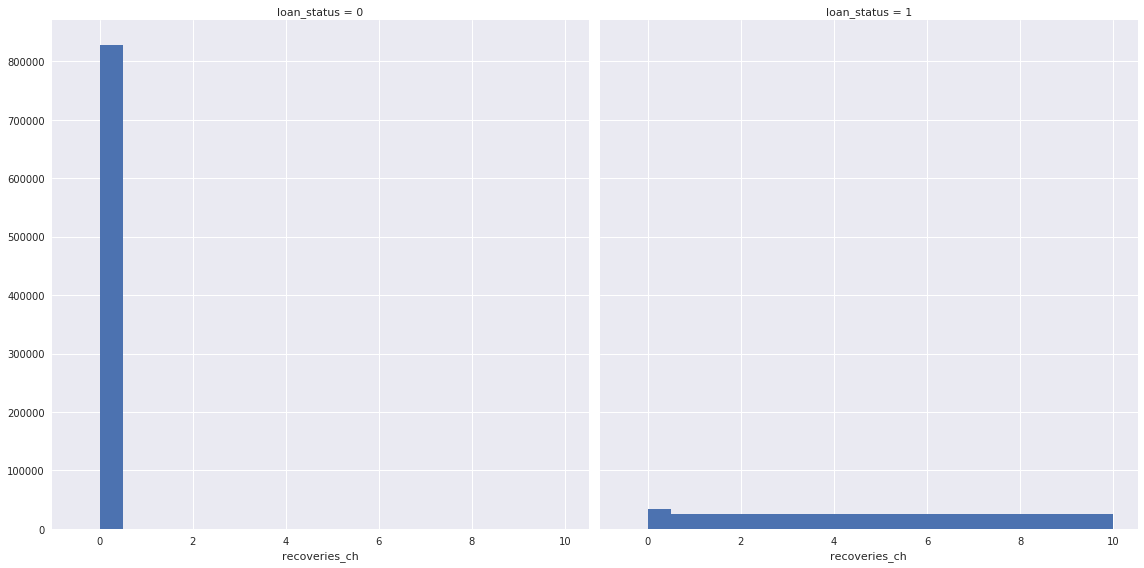

In [355]:
plot_me_proba('recoveries',0,[-0.5,0,0.5,10])

#### The great one

In [100]:
bin_it_wisely('recoveries',[-0.5,0,0.5,10])

[0, 1, 2]
[-0.5, 0, 0.5, 10]


### 4.1.23 collection_recovery_fee
post charge off collection fee

In [101]:
data.collection_recovery_fee_zero = data.collection_recovery_fee == 0

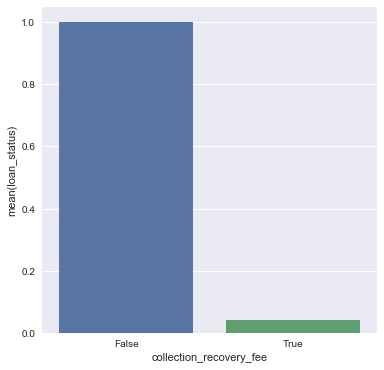

In [116]:
sns.barplot(x="collection_recovery_fee_zero", y="loan_status", data=data); 

#### Yet another strong indicator for default clients

### 4.1.24 last_pymnt_amnt
Last total payment amount received

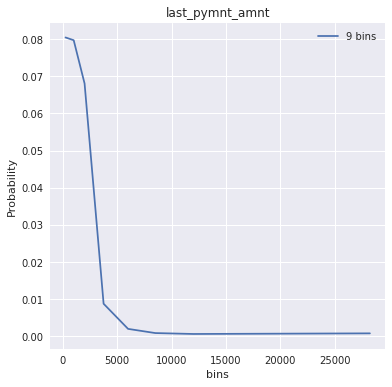

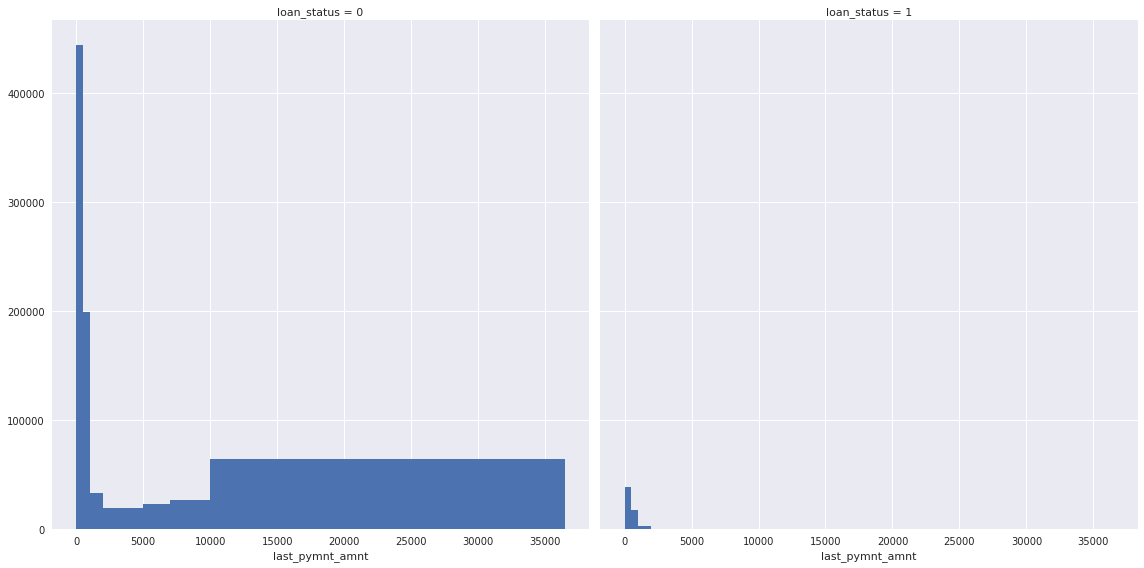

In [369]:
plot_me_proba('last_pymnt_amnt',0,[0,500,1000,2000,3500,5000,7000,10000,max(data.last_pymnt_amnt)])

In [102]:
bin_it_wisely('last_pymnt_amnt',[0,500,1000,2000,3500,5000,7000,10000,max(data.last_pymnt_amnt)])

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 500, 1000, 2000, 3500, 5000, 7000, 10000, 36475.589999999997]


### 4.1.25 annual_inc_joint
The combined self-reported annual income provided by the co-borrowers during registration

annual_inc_joint_nans  loan_status
0.0                    0              828051
                       1               58817
1.0                    0                 509
                       1                   2
Name: loan_status, dtype: int64


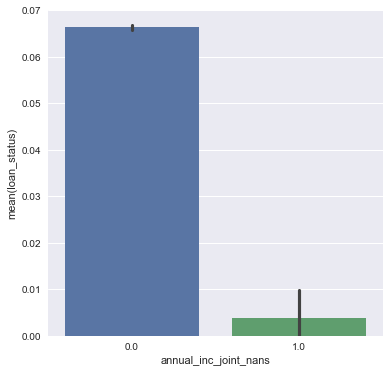

In [103]:
do_nans("annual_inc_joint") 

In [104]:
data.drop( ["annual_inc_joint"] , axis=1, inplace=True) 

### 4.1.26 dti_joint
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

dti_joint_nans  loan_status
0.0             0              828053
                1               58817
1.0             0                 507
                1                   2
Name: loan_status, dtype: int64


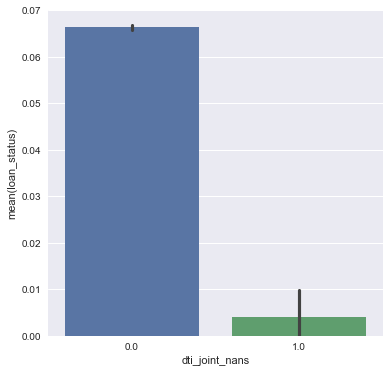

In [105]:
do_nans('dti_joint')

### 4.1.27 - 4.1.42  Columns with most missing values (over 850 000)
Here I'll turn theirs values into 1 if there is any value now, or replace it with 0 if there is NaN

In [106]:
# to less of this information is provided to fill other rows on this basis
to_be_del = ["inq_last_12m", "total_cu_tl", "inq_fi", "all_util","dti_joint", "max_bal_bc", "open_rv_24m",
             "open_rv_12m", "il_util", "total_bal_il", "mths_since_rcnt_il", "open_il_24m",
           "open_il_12m", "open_il_6m", "open_acc_6m"]
data[to_be_del].describe()

inq_last_12m   total_cu_tl        inq_fi      all_util   dti_joint  \
count  21372.000000  21372.000000  21372.000000  21372.000000  509.000000   
mean       1.977307      1.537058      0.943945     60.831939   18.310118   
std        2.874067      2.723339      1.446872     20.013254    7.169233   
min       -4.000000      0.000000      0.000000      0.000000    3.000000   
25%        0.000000      0.000000      0.000000     47.700000   13.200000   
50%        2.000000      0.000000      0.000000     61.900000   17.610000   
75%        3.000000      2.000000      1.000000     75.200000   22.650000   
max       32.000000     35.000000     17.000000    151.400000   43.860000   

          max_bal_bc   open_rv_24m   open_rv_12m       il_util   total_bal_il  \
count   21372.000000  21372.000000  21372.000000  18617.000000   21372.000000   
mean     5887.979740      2.975482      1.389060     71.535317   36552.811389   
std      5284.701239      2.631886      1.520129     23.022862   43103.833619   
min         0.000000      0.000000      0.000000      0.000000       0.000000   
25%      2411.000000      1.000000      0.000000     58.600000   10251.500000   
50%      4483.000000      2.000000      1.000000     74.900000   24684.500000   
75%      7771.500000      4.000000      2.000000     87.600000   47858.000000   
max    127305.000000     43.000000     22.000000    223.300000  878459.000000   

       mths_since_rcnt_il   open_il_24m   open_il_12m    open_il_6m  \
count        20810.000000  21372.000000  21372.000000  21372.000000   
mean            20.912686      1.674574      0.761651      2.928832   
std             27.209081      1.688725      0.996035      3.089987   
min              0.000000      0.000000      0.000000      0.000000   
25%              6.000000      0.000000      0.000000      1.000000   
50%             12.000000      1.000000      0.000000      2.000000   
75%             23.000000      2.000000      1.000000      4.000000   
max            363.000000     19.000000     12.000000     40.000000   

        open_acc_6m  
count  21372.000000  
mean       1.109021  
std        1.242675  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        2.000000  
max       14.000000

In [107]:
# backing up dataframe
#data.to_csv('data_bckp1.csv')

In [108]:
# Here is a piece of code that is gonna be used to turn them all into variable with suffix '_nan'
fp =0
a = 0

for columns in to_be_del:
    if (descNum[columns][0] < data.shape[0] and descNum[columns][0]>0):
        print (columns)
        do_nans(columns,0)    # don't do this for '_nans'!
        print('\n')
        #print(data[column].describe())
        a+=1
    fp+=1
print (a)
# dropping whole list of 15 columns
data.drop(to_be_del, axis=1, inplace=True)

inq_last_12m
inq_last_12m_nans  loan_status
0.0                0              807188
                   1               58819
1.0                0               21372
Name: loan_status, dtype: int64


total_cu_tl
total_cu_tl_nans  loan_status
0.0               0              807188
                  1               58819
1.0               0               21372
Name: loan_status, dtype: int64


inq_fi
inq_fi_nans  loan_status
0.0          0              807188
             1               58819
1.0          0               21372
Name: loan_status, dtype: int64


all_util
all_util_nans  loan_status
0.0            0              807188
               1               58819
1.0            0               21372
Name: loan_status, dtype: int64


dti_joint
dti_joint_nans  loan_status
0.0             0              828053
                1               58817
1.0             0                 507
                1                   2
Name: loan_status, dtype: int64


max_bal_bc
max_bal_bc_nans 

### 4.1.43 acc_now_delinq - comparison with zero
The number of accounts on which the borrower is now delinquent.

In [109]:
## put this into some bins   !
where_are_NaNs = np.isnan(data['acc_now_delinq'])
data['acc_now_delinq'][where_are_NaNs] = np.mean(data['acc_now_delinq'])     # this is the workaround

In [110]:
data['acc_now_delinq_zero'] =data['acc_now_delinq']==0
print (data.groupby('loan_status').acc_now_delinq_zero.value_counts())

loan_status  acc_now_delinq_zero
0            True                   824678
             False                    3882
1            True                    58558
             False                     261
Name: acc_now_delinq_zero, dtype: int64


loan_status  acc_now_delinq_zero
0            True                   824678
             False                    3882
1            True                    58558
             False                     261
Name: acc_now_delinq_zero, dtype: int64


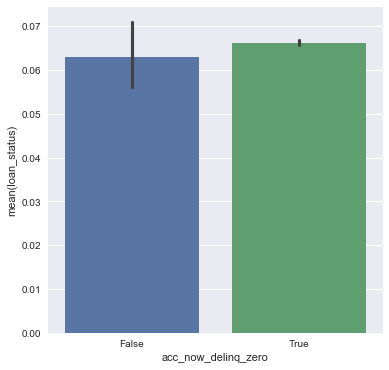

In [108]:

sns.barplot(x="acc_now_delinq_zero", y="loan_status", data=data); 
# its better this way

#### This is an example of insignificant variable

In [111]:
data.drop( ["acc_now_delinq_zero",'acc_now_delinq'] , axis=1, inplace=True)


### 4.1.44 collections_12_mths_ex_med - comparison with zero
Number of collections in 12 months excluding medical collections

collections_12_mths_ex_med_nans  loan_status
0.0                              0                 117
                                 1                  28
1.0                              0              828443
                                 1               58791
Name: loan_status, dtype: int64


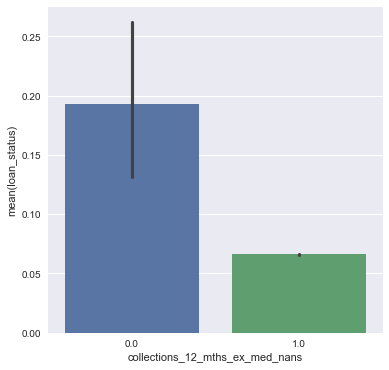

In [112]:
# Maybe we can do semething with collections_12_mths_ex_med
do_nans('collections_12_mths_ex_med')

In [113]:
data['collections_12_mths_ex_med_zero'] = data['collections_12_mths_ex_med']==0

loan_status  collections_12_mths_ex_med_zero
0            True                               817325
             False                               11235
1            True                                58228
             False                                 591
Name: collections_12_mths_ex_med_zero, dtype: int64


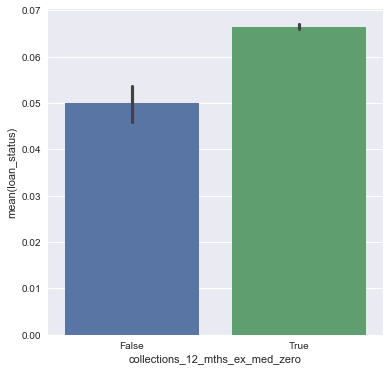

In [130]:
print (data.groupby('loan_status').collections_12_mths_ex_med_zero.value_counts())
sns.barplot(x="collections_12_mths_ex_med_zero", y="loan_status", data=data); 

In [114]:
data.collections_12_mths_ex_med.fillna(value=data["collections_12_mths_ex_med"].mean(), inplace=True)

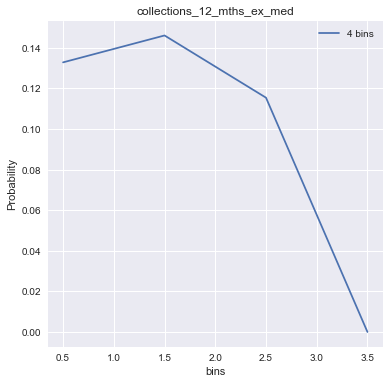

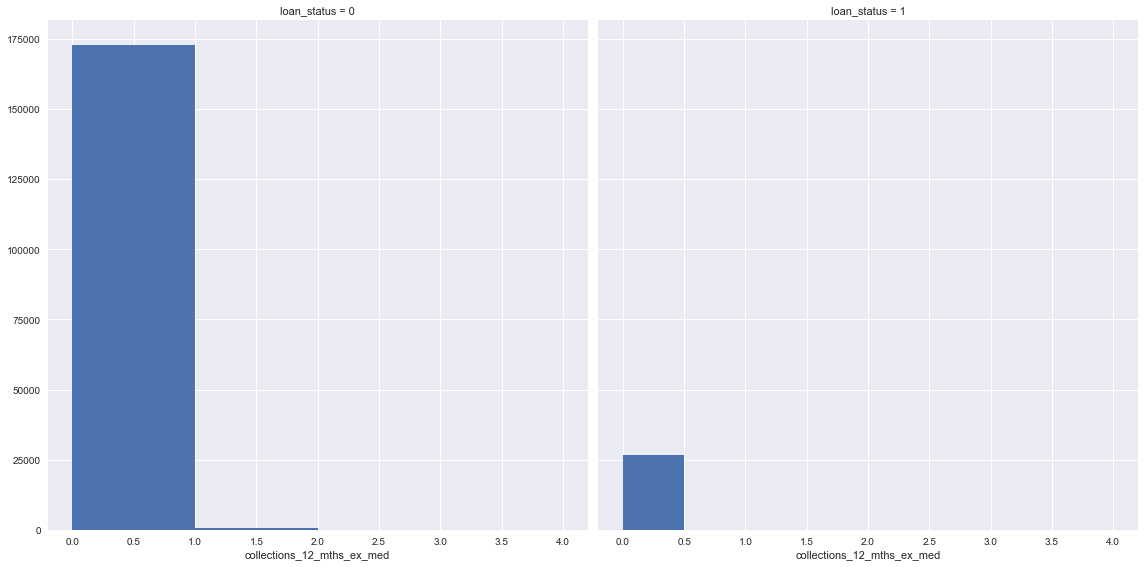

In [240]:
plot_me_proba('collections_12_mths_ex_med',4)

In [115]:
bin_it_wisely('collections_12_mths_ex_med',4)

[0, 1, 2, 3]
4


91

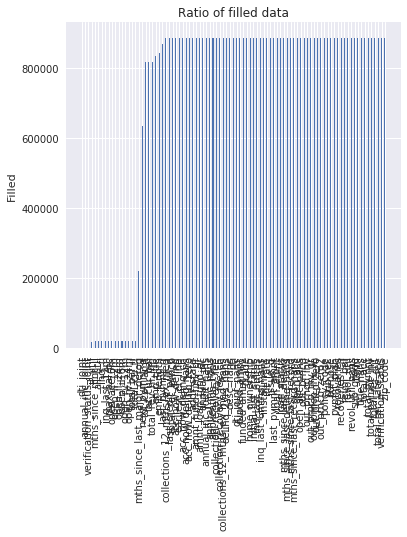

In [379]:
filled, filled_x = Data_plot_filled("filled_1")
filled_proc = [(filled[i]/data_nrows) for i in range(0, len(filled))]
len(filled_proc)

### 4.1.45 - 4.1.49  Group of missing values (over 50 000 missing)
I'll analyze each of them and try to find solution for missing values

In [117]:
next_del = ["verification_status_joint", "tot_coll_amt", "tot_cur_bal","total_rev_hi_lim","mths_since_last_major_derog"]
data[next_del].describe()

tot_coll_amt   tot_cur_bal  total_rev_hi_lim  \
count  8.171030e+05  8.171030e+05      8.171030e+05   
mean   2.257026e+02  1.394582e+05      3.206862e+04   
std    1.031137e+04  1.537500e+05      3.749826e+04   
min    0.000000e+00  0.000000e+00      0.000000e+00   
25%    0.000000e+00  2.985300e+04      1.390000e+04   
50%    0.000000e+00  8.055900e+04      2.370000e+04   
75%    0.000000e+00  2.082050e+05      3.980000e+04   
max    9.152545e+06  8.000078e+06      9.999999e+06   

       mths_since_last_major_derog  
count                221703.000000  
mean                     44.104838  
std                      22.179841  
min                       0.000000  
25%                      27.000000  
50%                      44.000000  
75%                      61.000000  
max                     188.000000

### 4.1.50  tot_coll_amt - comparison with zero
Total collection amounts ever owed


tot_coll_amt_nans  loan_status
0.0                0               59357
                   1               10919
1.0                0              769203
                   1               47900
Name: loan_status, dtype: int64


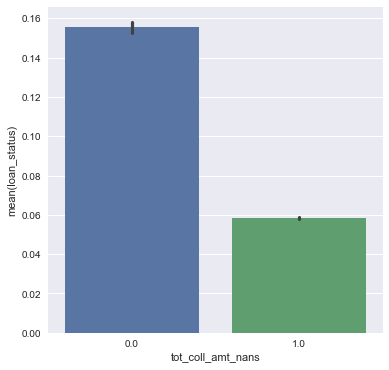

In [118]:
do_nans('tot_coll_amt')

woah, that was good! 

In [44]:
data["loan_status"].corr(data["tot_coll_amt"], method='spearman', min_periods=1)

0.006250494725817431

In [120]:
data['tot_coll_amt_zero'] = data['tot_coll_amt']== 0
print (data.groupby('loan_status').tot_coll_amt_zero.value_counts())

loan_status  tot_coll_amt_zero
0            True                 659220
             False                169340
1            True                  41726
             False                 17093
Name: tot_coll_amt_zero, dtype: int64


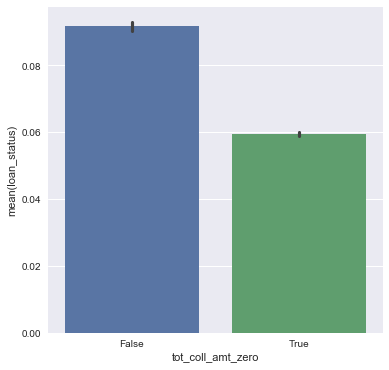

In [137]:
sns.barplot(x="tot_coll_amt_zero", y="loan_status", data=data); 

In [121]:
data.tot_coll_amt.fillna(value=data["tot_coll_amt"].mean(), inplace=True)

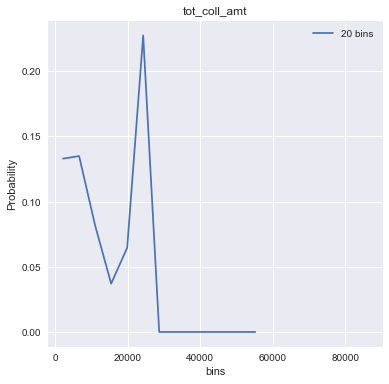

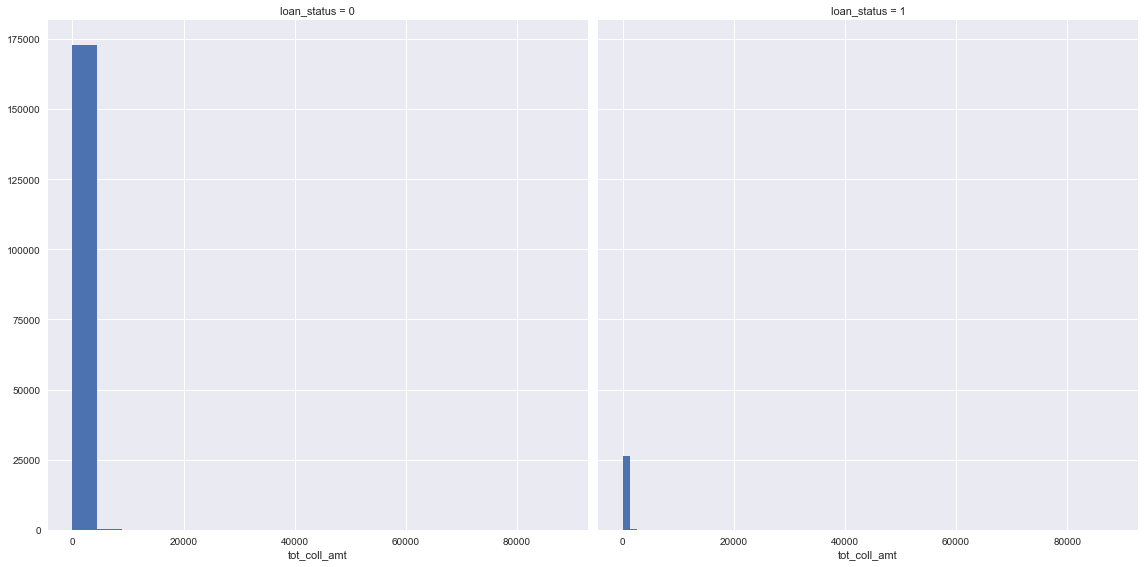

In [236]:
plot_me_proba('tot_coll_amt')

#### This lack any importance

In [122]:
data.drop('tot_coll_amt', axis=1, inplace=True)

### 4.1.51  tot_cur_bal
Total current balance of all accounts

tot_cur_bal_nans  loan_status
0.0               0               59357
                  1               10919
1.0               0              769203
                  1               47900
Name: loan_status, dtype: int64


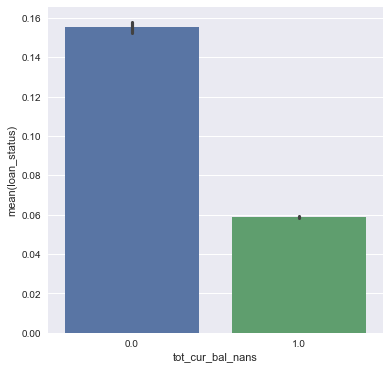

In [123]:
# This variable could provide some insights about using saved money to pay loan
do_nans("tot_cur_bal")

#### guys with nans looks a bit worse

In [124]:
data["loan_status"].corr(data["tot_cur_bal"], method='spearman', min_periods=1)
#data["tot_cur_bal_ch"]=data["tot_cur_bal"]

where_are_NaNs = np.isnan(data["tot_cur_bal"])
data["tot_cur_bal"][where_are_NaNs] =  np.mean(data["tot_cur_bal"])/4     # this is the workaround


### 4.1.52  tot_cur_bal_proc_amnt - Engineered Feature 
Ratio of toal current balance for all accounts to loan amount 
Indicate how much to the owner is his loan worth relatively

In [125]:
data["tot_cur_bal_proc_amnt"] = data["tot_cur_bal"]/data["loan_amnt"]

In [126]:
data['tot_cur_bal_proc_amnt'].describe()

count    887379.000000
mean         11.117052
std          17.343781
min           0.000000
25%           2.365702
50%           5.907231
75%          13.517938
max         747.130000
Name: tot_cur_bal_proc_amnt, dtype: float64

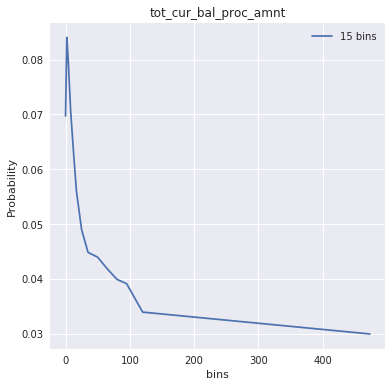

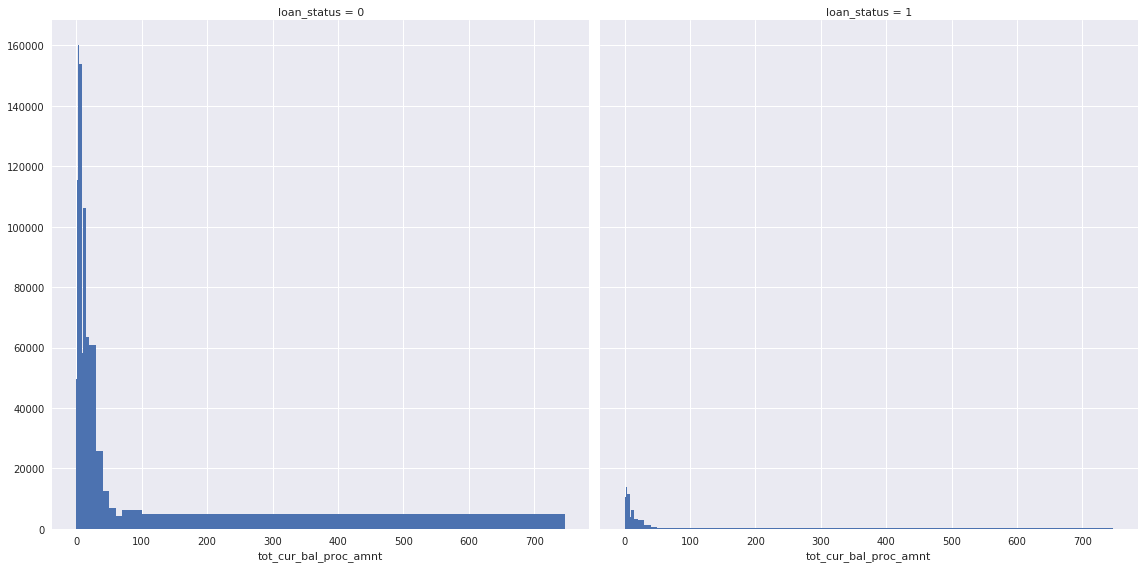

In [174]:
plot_me_proba("tot_cur_bal_proc_amnt",0,[0,1,2,4,8,10,15,20,30,40,50,60,70,100, max(data.tot_cur_bal_proc_amnt)]) 

#### and that is a nice trend. This should be binned

In [127]:
bin_it_wisely("tot_cur_bal_proc_amnt",[0,1,2,4,8,10,15,20,30,40,50,60,70,100,max(data.tot_cur_bal_proc_amnt)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 1, 2, 4, 8, 10, 15, 20, 30, 40, 50, 60, 70, 100, 747.13]


Lets see what else is there

### 4.1.53  total_rev_hi_lim
Total revolving high credit/credit limit

total_rev_hi_lim_nans  loan_status
0.0                    0               59357
                       1               10919
1.0                    0              769203
                       1               47900
Name: loan_status, dtype: int64


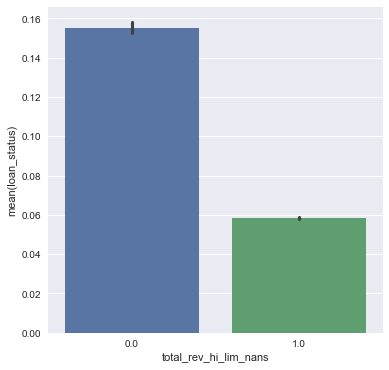

In [128]:
do_nans("total_rev_hi_lim")

In [129]:
data["loan_status"].corr(data["total_rev_hi_lim"], method='spearman', min_periods=1)

where_are_NaNs = np.isnan(data["total_rev_hi_lim"])
data["total_rev_hi_lim"][where_are_NaNs] = 0# np.mean(data["total_rev_hi_lim"])     # this is the workaround
data.total_rev_hi_lim[data.total_rev_hi_lim >= 100000] = 100000                # nasycenie

In [130]:
data.total_rev_hi_lim.describe()

count    887379.000000
mean      27946.753267
std       23393.836720
min           0.000000
25%       11650.000000
50%       21800.000000
75%       37800.000000
max      100000.000000
Name: total_rev_hi_lim, dtype: float64

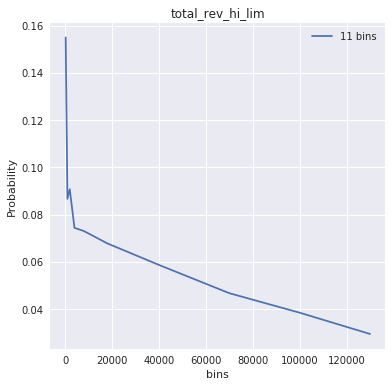

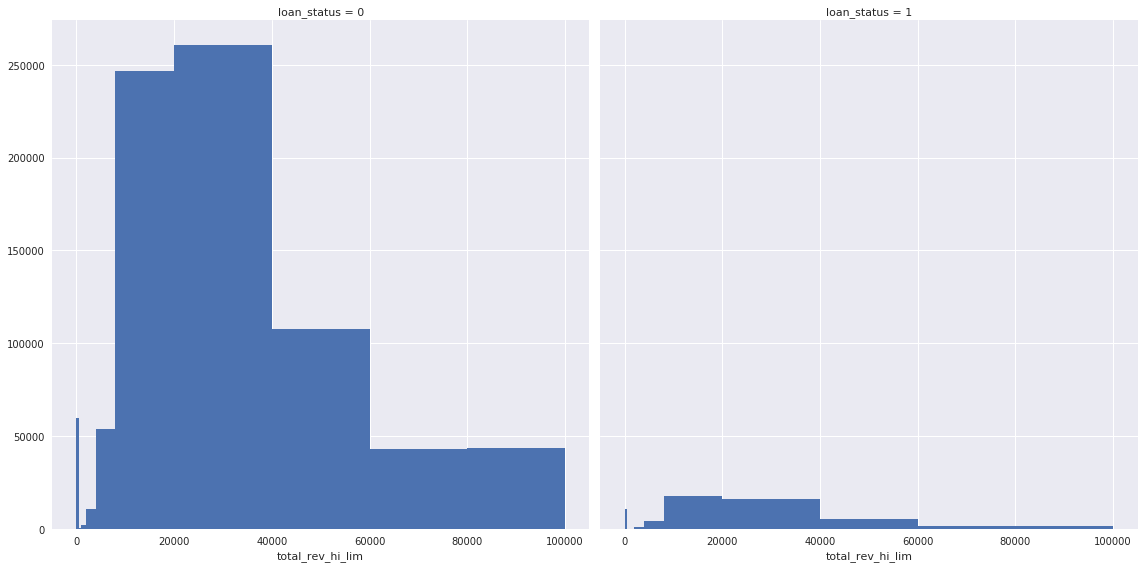

In [181]:
plot_me_proba("total_rev_hi_lim",0,[0,500,1000,2000,4000,8000,20000,40000,60000,80000, max(data.total_rev_hi_lim)]) 

In [131]:
bin_it_wisely("total_rev_hi_lim",[0,500,1000,2000,4000,8000,20000,40000,60000,80000, max(data.total_rev_hi_lim)]) 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 500, 1000, 2000, 4000, 8000, 20000, 40000, 60000, 80000, 100000.0]


### 4.1.54  mths_since_last_major_derog
Months since most recent 90-day or worse rating

mths_since_last_major_derog_nans  loan_status
0.0                               0              619307
                                  1               46369
1.0                               0              209253
                                  1               12450
Name: loan_status, dtype: int64


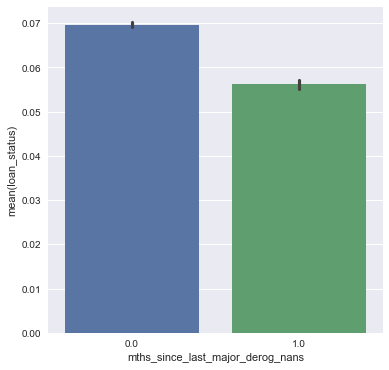

In [132]:
do_nans('mths_since_last_major_derog')

In [133]:
where_are_NaNs = np.isnan(data["mths_since_last_major_derog"])
data["mths_since_last_major_derog"][where_are_NaNs] = 0# np.mean(data["total_rev_hi_lim"])     # this is the workaround


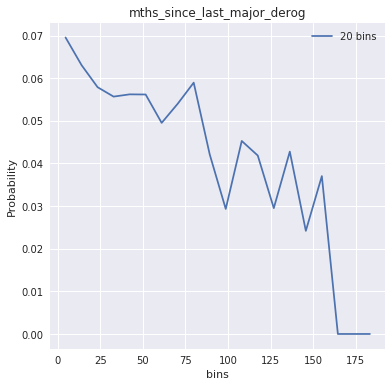

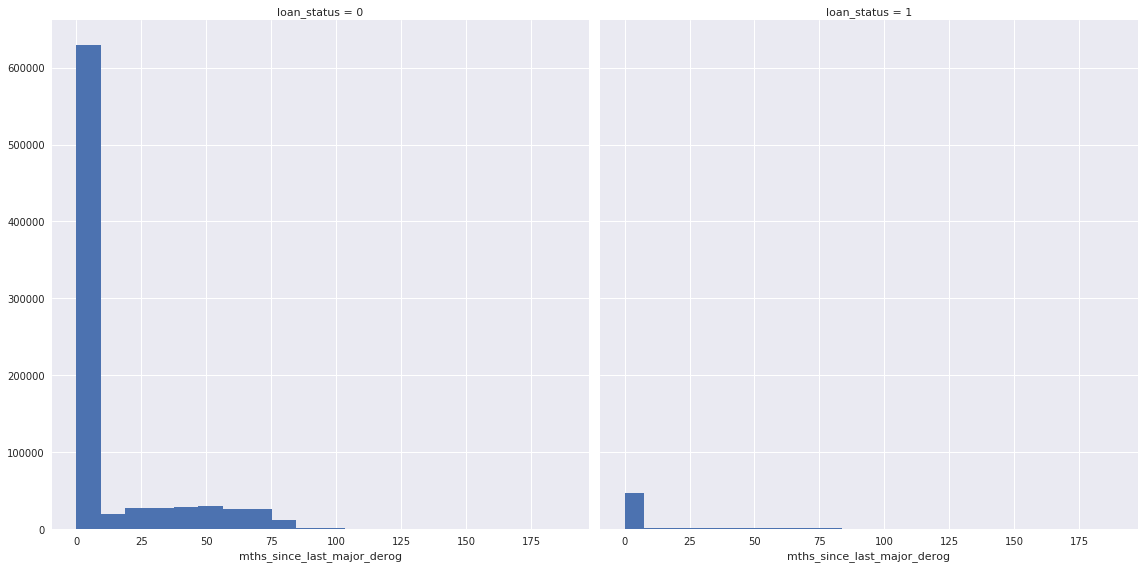

In [186]:
plot_me_proba('mths_since_last_major_derog')

In [134]:
# its insignificant
data.drop(['mths_since_last_major_derog', 'mths_since_last_major_derog_nans'], axis=1, inplace=True)

### 4.1.55  policy_code
"publicly available policy_code=1
new products not publicly available policy_code=2"

In [135]:
print (data.groupby('loan_status').policy_code.value_counts())
data.drop('policy_code', axis=1, inplace=True)

loan_status  policy_code
0            1.0            828560
1            1.0             58819
Name: policy_code, dtype: int64


### 4.1.55  install_proc_inc - Engineered Feature
Ratio of the monthly payment to the annual income
I hypothesize that the trend will show that it is hard to pay a loan without much more incomes

In [136]:
# Engineer it into something actually meaningful
install_proc_inc = data['installment']/data['annual_inc']
data["install_proc_inc"] = install_proc_inc

# check if there are some nasty nans
where_are_NaNs = np.isnan(install_proc_inc)
install_proc_inc[where_are_NaNs] = np.mean(install_proc_inc)     # this is the workaround

data["install_proc_inc"] = install_proc_inc

In [137]:
# there is significant trend for values below 0.02, where there is also a majority of records there
# some wise binning here must be taken 

# Here author skillfully plays with numbers and after a curtain goes up, you'll see only the magic
# pre-binning corelation is install_proc_inc           0.085540
prb_ipi_corr = data["loan_status"].corr(data["install_proc_inc"], method='spearman', min_periods=1)
prb_inst_corr = data["loan_status"].corr(data["installment"], method='spearman', min_periods=1)
print("pre-binning correlation with loan_status for installment is :      ",prb_inst_corr)
print("pre-binning correlation with loan_status for install_proc_inc is : ",prb_ipi_corr)
bins_install_proc_inc1 = [0.002*i for i in range(0,6)]
bins_install_proc_inc2 = [0.01 + 0.006*j for j in range(1,3)]
bins_install_proc_inc=bins_install_proc_inc1 + bins_install_proc_inc2 +[1]


pre-binning correlation with loan_status for installment is :       0.00896325888609
pre-binning correlation with loan_status for install_proc_inc is :  0.0650979151367


In [138]:
data.install_proc_inc[data.install_proc_inc >= 1] = 1

data.install_proc_inc.fillna(value=data["install_proc_inc"].median(), inplace=True)

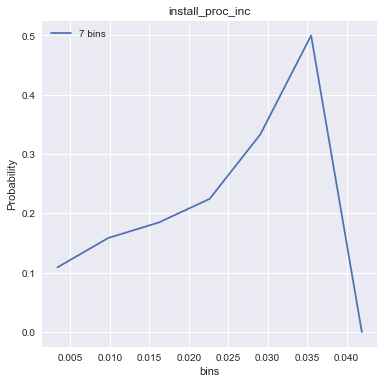

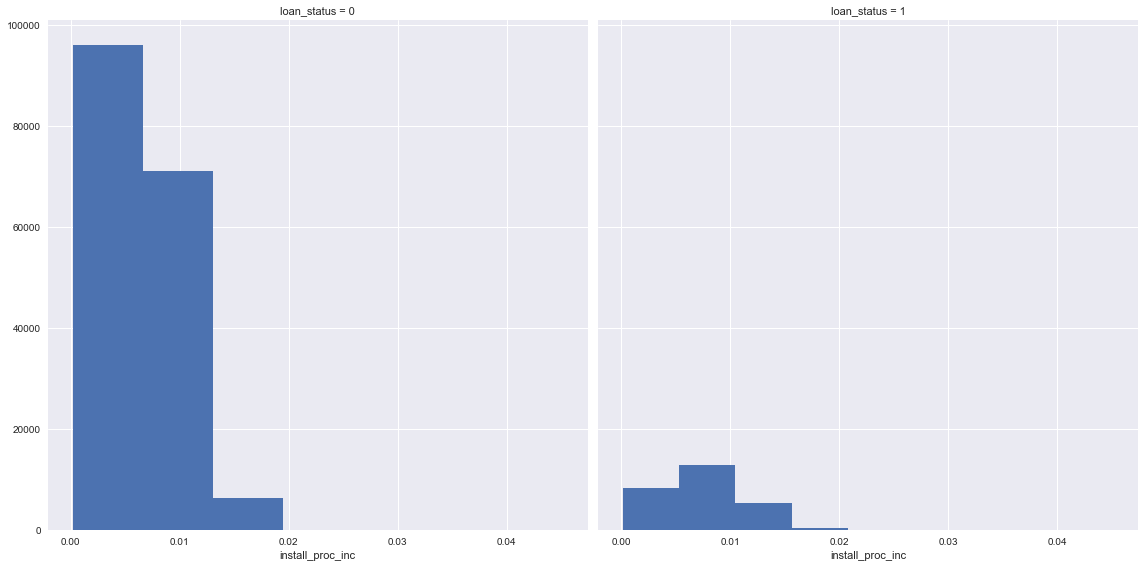

In [188]:
# now there is a nice trend visible!
plot_me_proba("install_proc_inc",7)

In [142]:
bins_install_proc_inc

[0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.016, 0.022, 1]

In [143]:
bin_it_wisely("install_proc_inc",bins_install_proc_inc)

[0, 1, 2, 3, 4, 5, 6, 7]
[0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.016, 0.022, 1]


### 4.1.55  total_pymnt_proc - Engineered Feature
Ratio of the payment received to funded loan amount 
This will indicate how much of the loan was paid, before assigning loan_status 

In [144]:
data['total_pymnt_proc'] = data["total_pymnt"]/data['funded_amnt']

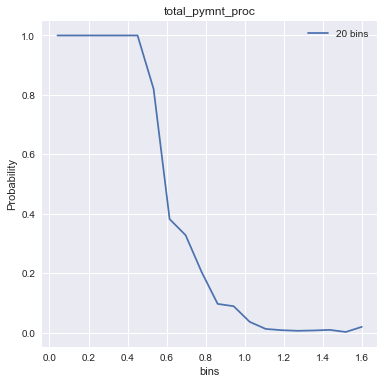

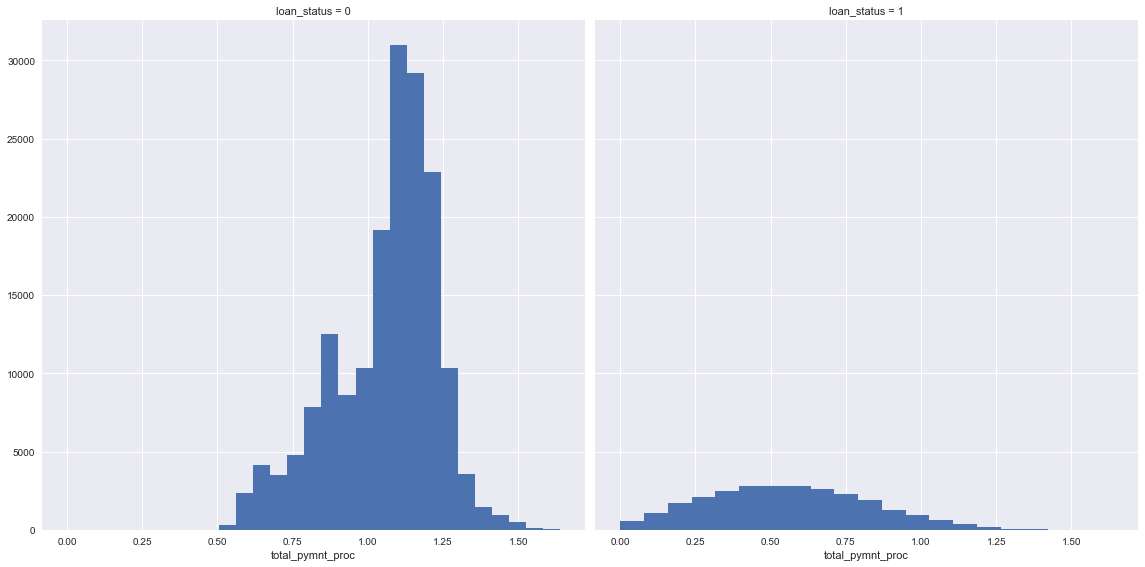

In [205]:
plot_me_proba("total_pymnt_proc")

Looking at the scale on the left (upper figure) and kind-of-mutually-exclusive distribution (lower graphs) I think it will be strong feature

In [145]:
bin_it_wisely("total_pymnt_proc",20)  #

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
20


In [146]:
data.to_csv('data_bckp2.csv')

In [184]:
#data2= pd.read_csv('data_bckp2.csv',encoding = "ISO-8859-1", low_memory=False)
#data2.drop('Unnamed: 0',axis=1, inplace=True)
#data3=data
#data=data2

In [147]:
data.head()

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0     5000.0       5000.0           4975.0   36 months     10.65       162.87   
1     2500.0       2500.0           2500.0   60 months     15.27        59.83   
2     2400.0       2400.0           2400.0   36 months     15.96        84.33   
3    10000.0      10000.0          10000.0   36 months     13.49       339.31   
4     3000.0       3000.0           3000.0   60 months     12.69        67.79   

  grade sub_grade                 emp_title emp_length home_ownership  \
0     B        B2                       NaN  10+ years           RENT   
1     C        C4                     Ryder   < 1 year           RENT   
2     C        C5                       NaN  10+ years           RENT   
3     C        C1       AIR RESOURCES BOARD  10+ years           RENT   
4     B        B5  University Medical Group     1 year           RENT   

   annual_inc verification_status  issue_d  loan_status pymnt_plan  \
0     24000.0            Verified       54            0          n   
1     30000.0     Source Verified       54            1          n   
2     12252.0        Not Verified       54            0          n   
3     49200.0     Source Verified       54            0          n   
4     80000.0     Source Verified       54            0          n   

          purpose zip_code addr_state    dti  earliest_cr_line  \
0     credit_card    860xx         AZ  27.65               363   
1             car    309xx         GA   1.00               534   
2  small_business    606xx         IL   8.72               565   
3           other    917xx         CA  20.00               496   
4           other    972xx         OR  17.94               495   

   inq_last_6mths  mths_since_last_record  open_acc  pub_rec  revol_bal  \
0             1.0               70.117903       3.0      0.0    13648.0   
1             5.0               70.117903       3.0      0.0     1687.0   
2             2.0               70.117903       2.0      0.0     2956.0   
3             1.0               70.117903      10.0      0.0     5598.0   
4             0.0               70.117903      15.0      0.0    27783.0   

   revol_util  total_acc initial_list_status  out_prncp  out_prncp_inv  \
0        83.7        9.0                   f        0.0            0.0   
1         9.4        4.0                   f        0.0            0.0   
2        98.5       10.0                   f        0.0            0.0   
3        21.0       37.0                   f        0.0            0.0   
4        53.9       38.0                   f      766.9          766.9   

    total_pymnt  total_pymnt_inv  total_rec_int  recoveries  \
0   5861.071414          5831.78         861.07         0.0   
1   1008.710000          1008.71         435.17        10.0   
2   3003.653644          3003.65         603.65         0.0   
3  12226.302212         12226.30        2209.33         0.0   
4   3242.170000          3242.17        1009.07         0.0   

   collection_recovery_fee  last_pymnt_d  last_pymnt_amnt  next_pymnt_d  \
0                     0.00            86           171.62             0   
1                     1.11            65           119.66             0   
2                     0.00            79           649.91             0   
3                     0.00            86           357.48             0   
4                     0.00            98            67.79            99   

   last_credit_pull_d  collections_12_mths_ex_med application_type  \
0                 103                         0.0       INDIVIDUAL   
1                  75                         0.0       INDIVIDUAL   
2                 103                         0.0       INDIVIDUAL   
3                  91                         0.0       INDIVIDUAL   
4                 103                         0.0       INDIVIDUAL   

  verification_status_joint   tot_cur_bal  total_rev_hi_lim desc_nans  \
0                       NaN  34864.5473

## 4.2 Objective variables
Now simplify objective columns and turn them into numbers. It will be achieved by sorting every column unique values, and then transforming column to numerical series based on this sorted 'vocabulary'

In [148]:
descObj = data.describe(include=[np.object])

In [149]:
descObj

term   grade sub_grade emp_title emp_length home_ownership  \
count       887379  887379    887379    835917     842554         887379   
unique           2       7        35    299271         11              6   
top      36 months       B        B3   Teacher  10+ years       MORTGAGE   
freq        621125  254535     56323     13469     291569         443557   

       verification_status pymnt_plan             purpose zip_code addr_state  \
count               887379     887379              887379   887379     887379   
unique                   3          2                  14      935         51   
top        Source Verified          n  debt_consolidation    945xx         CA   
freq                329558     887369              524215     9770     129517   

       initial_list_status application_type verification_status_joint  \
count               887379           887379                       511   
unique                   2                2                         3   
top                      f       INDIVIDUAL              Not Verified   
freq                456848           886868                       283   

        desc_nans  title_nans issue_dmo earliest_cr_linemo last_pymnt_dmo  \
count      887379      887379    887379             887379         887379   
unique          2           2        12                 12             12   
top             0           1         j                  h              a   
freq       761351      887227    111971              86474         502657   

       next_pymnt_dmo last_credit_pull_dmo  
count          887379               887379  
unique             12                   12  
top                 b                    a  
freq           553615               738304

### 4.3.1 emp_title
The job title supplied by the Borrower when applying for the loan.*

*Employer Title replaces Employer Name for all loans listed after 9/23/2013


In [150]:
# There is too much job titles
data.drop( ["emp_title"] , axis=1, inplace=True)

### 4.3.2 emp_length
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

In [151]:
# TESTING MY HYPOTHESIS:
data['emp_length'].replace(['10+ years'], [11],inplace=True)
data['emp_length'].replace(['< 1 year'], [0],inplace=True)
data.replace('n/a', np.nan, inplace=True)

In [152]:
data['emp_length'].replace([str(i) for i in range(1,10)], [i for i in range(1,10)], inplace=True, regex=True)

emp_length_nans  loan_status
0.0              0               41495
                 1                3330
1.0              0              787065
                 1               55489
Name: loan_status, dtype: int64


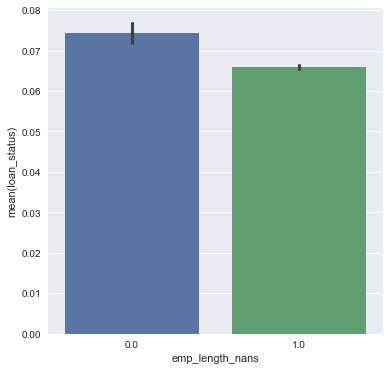

In [153]:
do_nans('emp_length')

In [154]:
data.emp_length.fillna(value=data["emp_length"].median(), inplace=True)

In [155]:
print(list(data['emp_length'].unique()))

[11.0, 0.0, 1.0, 3.0, 8.0, 9.0, 4.0, 5.0, 6.0, 2.0, 7.0]


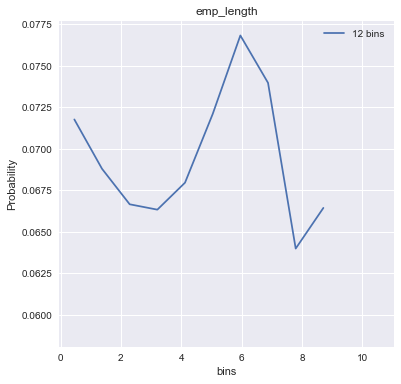

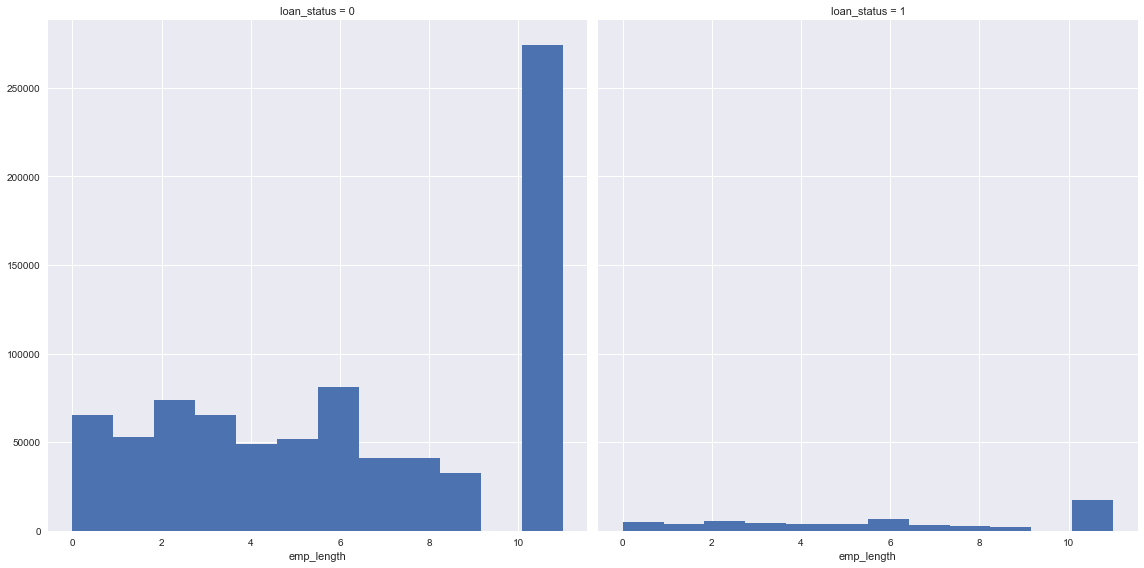

In [241]:
plot_me_proba("emp_length",12)

Well, this feature alone isn't very informative to me, but mybe it could be somehow used by classifier 

### 4.3.3 Transforming Objective values to numerical and Final Encoding

Here I will drop last unnecessary columns and perfomr one-hot encoding for some categorical variables, and translate some objects into numbers

In [156]:
descObj = data.describe(include=[np.object])

In [157]:
data.drop( ["verification_status_joint",'zip_code'] , axis=1, inplace=True)

In [158]:
data.drop( ["funded_amnt","funded_amnt_inv"] , axis=1, inplace=True)

In [159]:
# Dummy here!
# Create a set of dummy variables from the purpose variable
df_purpose = pd.get_dummies(data['purpose'], prefix='purpose' )
df_home_ownership = pd.get_dummies(data['home_ownership'],  prefix='home_ownership' )
df_addr_state = pd.get_dummies(data['addr_state'],  prefix='addr_state' )


# Join the dummy variables to the main dataframe
df_new = pd.concat([data, df_purpose,df_home_ownership,df_addr_state], axis=1)
data = df_new
data.drop(['purpose','home_ownership','addr_state'], axis=1, inplace=True)

In [161]:
data.shape

(887379, 182)

In [163]:
# Refresh values
descObj = data.describe(include=[np.object])


In [164]:
# Change this into numerical variables  
do_cats_to_nums(descObj)

term object
grade object
sub_grade object
verification_status object
pymnt_plan object
initial_list_status object
application_type object
issue_dmo object
earliest_cr_linemo object
last_pymnt_dmo object
next_pymnt_dmo object
last_credit_pull_dmo object


No more CATEGORICAL VARIABLES!!


### Now this is G R E A T  information
We can now move slowly to training our models

In [166]:
# check fillingness now
for column in data:
    if data[column].isnull().sum()>0:
        print (column, data[column].isnull().sum())

### There is no empty cells

In [170]:
for column in data:
    print(column, data[column].dtype)

loan_amnt float64
term int64
int_rate float64
installment float64
grade int64
sub_grade int64
emp_length float64
annual_inc float64
verification_status int64
issue_d int64
loan_status int64
pymnt_plan int64
dti float64
earliest_cr_line int64
inq_last_6mths float64
mths_since_last_record float64
open_acc float64
pub_rec float64
revol_bal float64
revol_util float64
total_acc float64
initial_list_status int64
out_prncp float64
out_prncp_inv float64
total_pymnt float64
total_pymnt_inv float64
total_rec_int float64
recoveries float64
collection_recovery_fee float64
last_pymnt_d int64
last_pymnt_amnt float64
next_pymnt_d int64
last_credit_pull_d int64
collections_12_mths_ex_med float64
application_type int64
tot_cur_bal float64
total_rev_hi_lim float64
desc_nans int64
title_nans int64
issue_dyr int32
issue_dmo int64
earliest_cr_lineyr int32
earliest_cr_linemo int64
last_pymnt_dyr int32
last_pymnt_dmo int64
next_pymnt_dyr int32
next_pymnt_dmo int64
last_credit_pull_dyr int32
last_credit_pull_

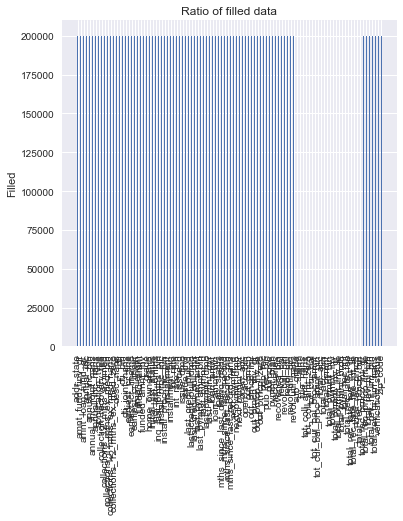

In [251]:

filled, filled_x = Data_plot_filled("filled_1")
filled_proc = [(filled[i]/data_nrows) for i in range(0, len(filled))]

In [234]:
#corr_tau_kendala = data.corr(method='kendall', min_periods=1)
corr_pearson = data.corr(method='pearson', min_periods=1)
#corr_spearman = data.corr(method='spearman', min_periods=1)

In [257]:
abs(corr_pearson['loan_status']).sort_values()

title_nans                         0.000506
open_acc                           0.000592
collections_12_mths_ex_med         0.001472
pymnt_plan                         0.001544
annual_inc_nans                    0.001750
mths_since_last_delinq_nans        0.002872
revol_util_nans                    0.003336
pub_rec                            0.003390
collections_12_mths_ex_med_zero    0.003783
collections_12_mths_ex_med_nans    0.004785
zip_code                           0.006309
addr_state                         0.007102
amnt_fund_finv_gr                  0.007168
earliest_cr_linemo                 0.008116
mths_since_last_record             0.008152
emp_length                         0.011330
desc_nans                          0.011905
mths_since_last_record_nans        0.012058
funded_amnt_inv                    0.013218
amnt_loan_fund_gr                  0.014598
installment                        0.015411
last_credit_pull_dyr               0.015713
revol_bal                       

#### Near the top of the most important variables are designed by me features: total_pymnt_proc, total_rec_prncp_int_gr/le, last_pymnt_d, out_prncp_zero, next_pymnt_d, next_pymnt_dyr, total_pymnt_inv_le, last_credit_pull_d, last_pymnt_dyr, last_pymnt_dmo

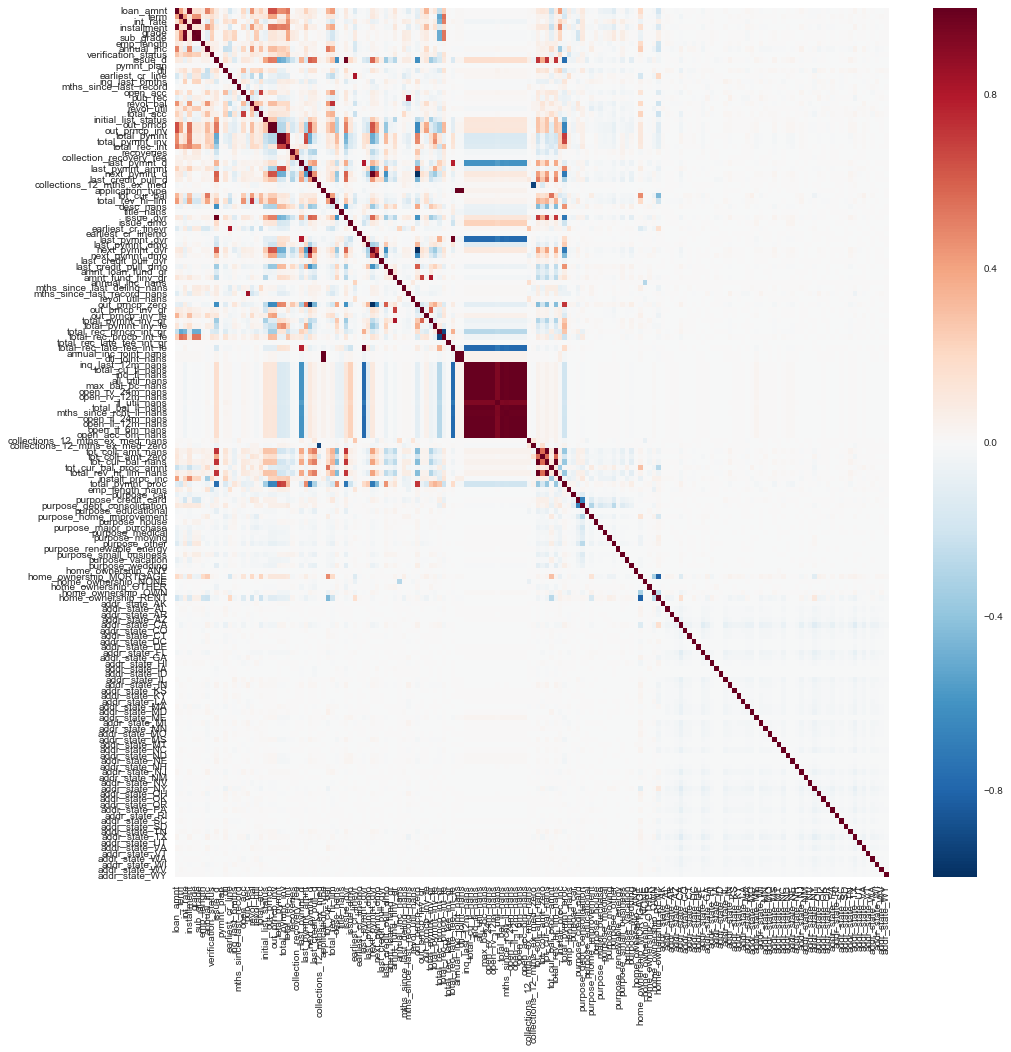

In [236]:
#Lets go for visuals
#abs(corr_spearman['loan_status']).sort_values()
sns.set(rc={"figure.figsize": (16, 16)})
sns.heatmap(corr_pearson)
## * Note * This may not be well visible for such an amount of features

Now we can see how much of the data isn't filled,
    lets drop columns with missing values

In [ ]:
# If there is any unwanted objective column we can drop it here
objList = list(descObj)
objList
#data.drop( objList , axis=1, inplace=True)
print(data.shape)

In [261]:
#drop column that is not filled in 100%
data.dropna(axis=1, how='any', inplace=True)
print(data.shape)

(200000, 102)


# 5. Modeling with SciKit-Learn
Here I will use mostly sklearn library to obtain models and train them

In [172]:
#  Importing Modelling Algorithms
import sklearn
print(sklearn.__version__)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

0.18.1


C:\Users\Józef\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [173]:
# only for later versions!  If __version__ >= 18.0 then:
from sklearn.model_selection import train_test_split  
Y = data["loan_status"]
data.drop(["loan_status"], axis=1, inplace=True)

## 5.1 Splitting data into train set
I'am splitting into train_valid that consists of 70% of the data and test that covers 30%

In [174]:
# Split into 70/30 ratio
X_train_valid, X_test, y_train_valid, y_test = train_test_split(data, Y, test_size=0.30, random_state=42)

In [175]:
# without deleting 70/30 chunks, I will split 70% od original dataset into 14/56
X_train,X_valid,y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.30, random_state=42)
print (X_test.shape, y_test.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(266214, 181) (266214,) (434815, 181) (434815,) (186350, 181) (186350,)


In [177]:
print(X_train_valid.shape, y_train_valid.shape)

(621165, 181) (621165,)


### 5.2 Show estimated variable importance
*NOTE* This won't be readable for bigger amount of features

1.0


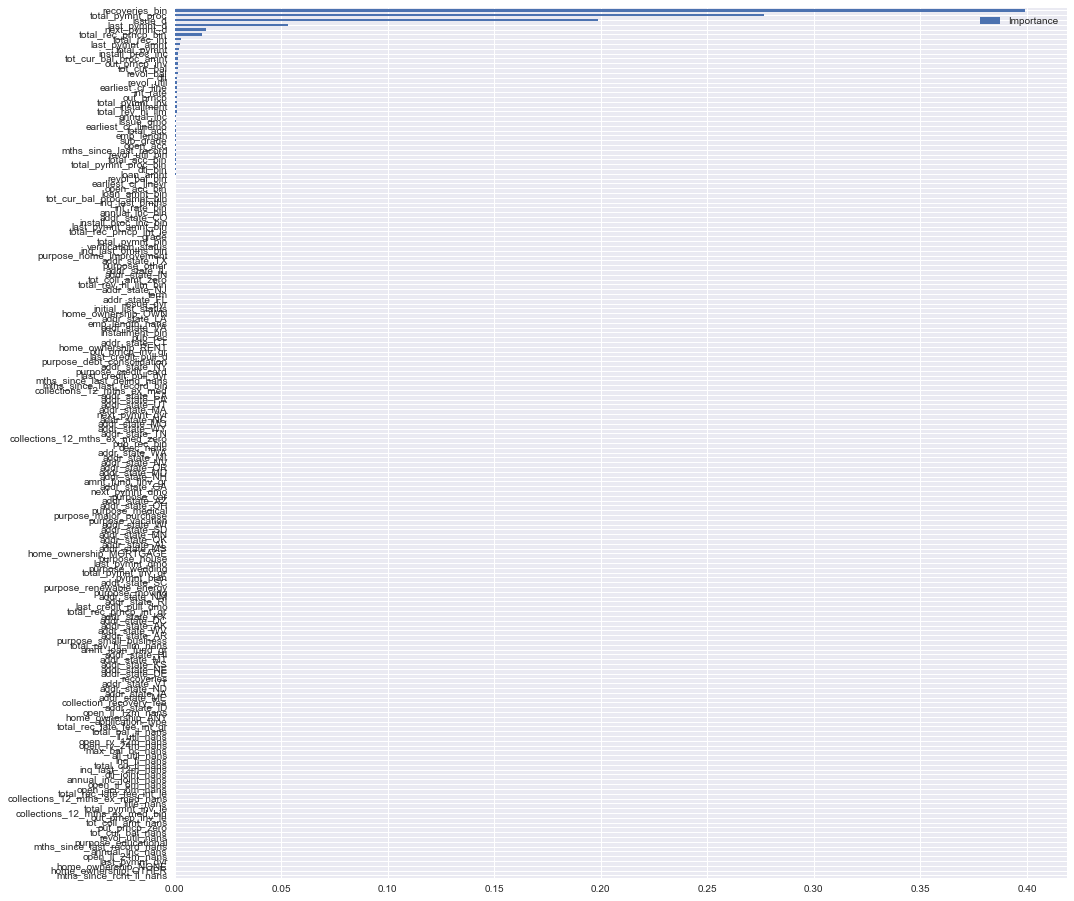

In [231]:
plt.figure(figsize=(width, height), dpi= 600)
matplotlib.rcParams['figure.figsize']= [16, 16]
imp = plot_variable_importance(X_train, y_train)

In [179]:
print(imp)

                                 Importance
mths_since_rcnt_il_nans            0.000000
home_ownership_OTHER               0.000000
home_ownership_NONE                0.000000
last_pymnt_dyr                     0.000000
open_il_24m_nans                   0.000000
annual_inc_nans                    0.000000
mths_since_last_record_nans        0.000000
purpose_educational                0.000000
revol_util_nans                    0.000000
tot_cur_bal_nans                   0.000000
out_prncp_zero                     0.000000
tot_coll_amt_nans                  0.000000
out_prncp_inv_le                   0.000000
collections_12_mths_ex_med_bin     0.000000
total_pymnt_inv_le                 0.000000
title_nans                         0.000000
collections_12_mths_ex_med_nans    0.000000
total_rec_late_fee_int_le          0.000000
open_acc_6m_nans                   0.000000
open_il_6m_nans                    0.000000
annual_inc_joint_nans              0.000000
dti_joint_nans                  

## 5.3 Import classifier

In [180]:
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
import time

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# this depends on machine You use
#!/usr/bin/env python -W ignore::DeprecationWarning

## 5.4 Define function to be used for measuring purposes

In [194]:
def RunModels(names_loc,clf_loc):
    start = time.time()
    print(names_loc,clf_loc)
    plt.figure()
    for name,clf in zip(names_loc,clf_loc):
        print('Running '+name+' model')
        clf.fit(X_train_valid, y_train_valid)
        y_proba = clf.predict_proba(X_test)[:,1]
        ROC = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro')
        print("Roc AUC: "+name, ROC )
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=name)

    # show results
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    
    # save results
    plt.savefig('ROC_.png')
    plt.show()    
    # measure time
    end = time.time()
    print( end-start)
    return fpr, tpr, ROC

## 5.5 Define and initialize classifier

In [215]:
## This is piece of code for experimental purposes

#clfSVC = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=True, tol=0.01, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)

clfKNN = KNeighborsClassifier(n_neighbors = 3)
clfMLP = MLPClassifier(hidden_layer_sizes=(200, ), activation='logistic', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
clfDTC = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=4, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_split=1e-07, class_weight=None, presort=False)
#clfLSVC = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True,
#                    intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)  # nie ma proba ,Ridge też
clfGNB = GaussianNB()
clfDC = DummyClassifier(strategy='stratified', random_state=None, constant=None)
clfADA = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
clfBC = BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, random_state=None, verbose=0)
clfETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=False, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
clfLR = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
clfSGDC = SGDClassifier(loss='modified_huber', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, n_iter=5, shuffle=True,
verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, class_weight=None,warm_start=False, average=False)
clfGBC = GradientBoostingClassifier()
clfRFC = RandomForestClassifier()


clfVOTE = VotingClassifier(estimators=[
    #('SVC', clfSVC), 
    ('KNN', clfKNN), ('MLP', clfMLP), ('dtc', clfDTC), ('gnb', clfGNB),('DC', clfDC), 
    ('ADA', clfADA), ('BC', clfBC), ('ETC', clfETC), ('LR', clfLR), ('SGDC', clfSGDC), ('RFC', clfRFC), 
    ('GBC', clfGBC)],        # ('GPC', clfGNB)], 
                           voting='soft')

clfGBC = GradientBoostingClassifier()

#names = ["RFC","GBC","KNN","MLP"]
names = ["ADA",
         #"KNN",
         #"MLP","DTC","GNB","DC","ADA","BC","ETC","LR","SGDC",
         #"RFC"
         #,"GBC",#"GPC",
#    "VOTE"
]


clfs = [
#clfKNN,
#clfMLP,
#clfDTC,
#clfGNB,
#clfDC,
clfADA,
#clfBC,
#clfETC,
#clfLR,
#clfSGDC,
#clfRFC,
#clfGBC,
  #clfGPC,
   #clfVOTE
]

## 5.6 Running basic models
Here I will run only basics models, without changing theirs properties
Lets see how good are those models for my dataset

### 5.6.1 AdaBoost Classifier

Running A model
Roc AUC: A 0.990669226647


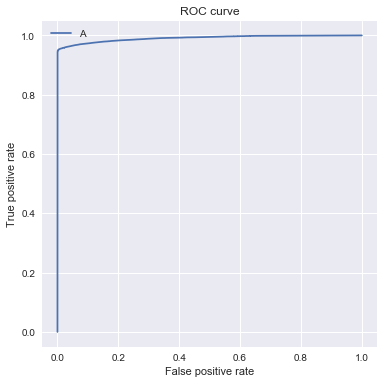

336.64367389678955


In [189]:
# Use AdaBoost with 50 estimators
fprADA, tprADA, ROC_ADA = RunModels(["ADA"], [clfADA])

#### Very good classification for quite small number of classifiers. Training and fitting took about 5 minutes 36 sec. 

### 5.6.2 GradientBoost  Classifier

['GBC'] [GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)]
Running GBC model
Roc AUC: GBC 0.992454882921


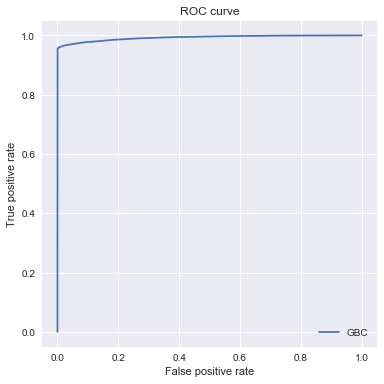

820.3288781642914


In [195]:
fprGBC, tprGBC, ROC_GBC = RunModels(["GBC"], [clfGBC])

#### Another boosting algorithm achieved better results, but also has spendt13 minutes 40 seconds on training and fitting

### 5.6.3 K-Nearest-Neigbors Classifier

['KNN'] [KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')]
Running KNN model
Roc AUC: KNN 0.829627964869


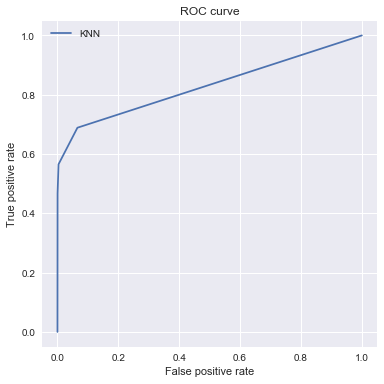

453.40887689590454


In [197]:
fprKNN, tprKNN, ROC_KNN = RunModels(["KNN"], [clfKNN])

#### Very simple algorithm failed to find a clue in the data

### 5.6.4 Random Forest Classifier

['RFC'] [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)]
Running RFC model
Roc AUC: RFC 0.984928285849


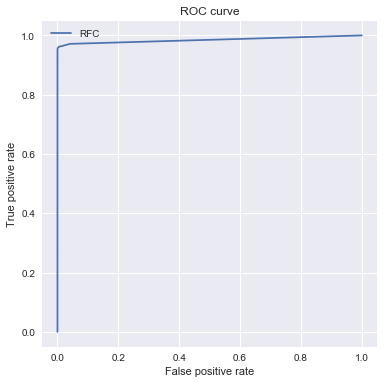

129.38909935951233


In [198]:
fprRFC, tprRFC, ROC_RFC = RunModels(["RFC"], [clfRFC])

#### Very fast algorithm and nice results. Lets change number of classifiers to see how it scales!



### 5.6.5 Random Forest Classifier Revisited -> 100 estimators

In [212]:
clfRFC100 = RandomForestClassifier(n_estimators=100, min_samples_split=2, n_jobs=-1)

['RFC100'] [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)]
Running RFC100 model
Roc AUC: RFC100 0.993560799397


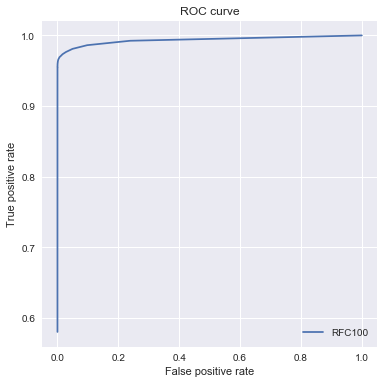

294.224826335907


In [213]:
fprRFC100, tprRFC100, ROC_RFC100 = RunModels(["RFC100"], [clfRFC100])

#### Still fast and finnally  - much better.

# 5.7 Classification results for default settings:

In [214]:
from sklearn.metrics import make_scorer, accuracy_score
clasifs = [clfGBC,clfRFC,clfKNN,clfADA,clfRFC100]
clasifs_n = ['GBC','RFC','KNN','ADA','RFC100']
ACC =[]
for cp in range(0,len(clasifs)):
    predictions = clasifs[cp].predict(X_test)
    ACC.append( accuracy_score(y_test, predictions))
    print(clasifs_n[cp], ACC[cp])

GBC 0.996472762514
RFC 0.996555402796
KNN 0.967800341079
ADA 0.995650116072
RFC100 0.996649312207


## ------------Roc AUC:------------------------Accuracy:
## ADA ----- 0.990669226647 ------------ 0.995650116072
## GBC ----- 0.992454882921 ------------ 0.996472762514
## KNN ----- 0.829627964869 ------------ 0.967800341079
## RFC ----- 0.984928285849 ------------ 0.996555402796

## Classification results for changed parameters
## RFC100 - 0.993560799397 ------------ 0.996649312207

# 5.8 Comparison graph

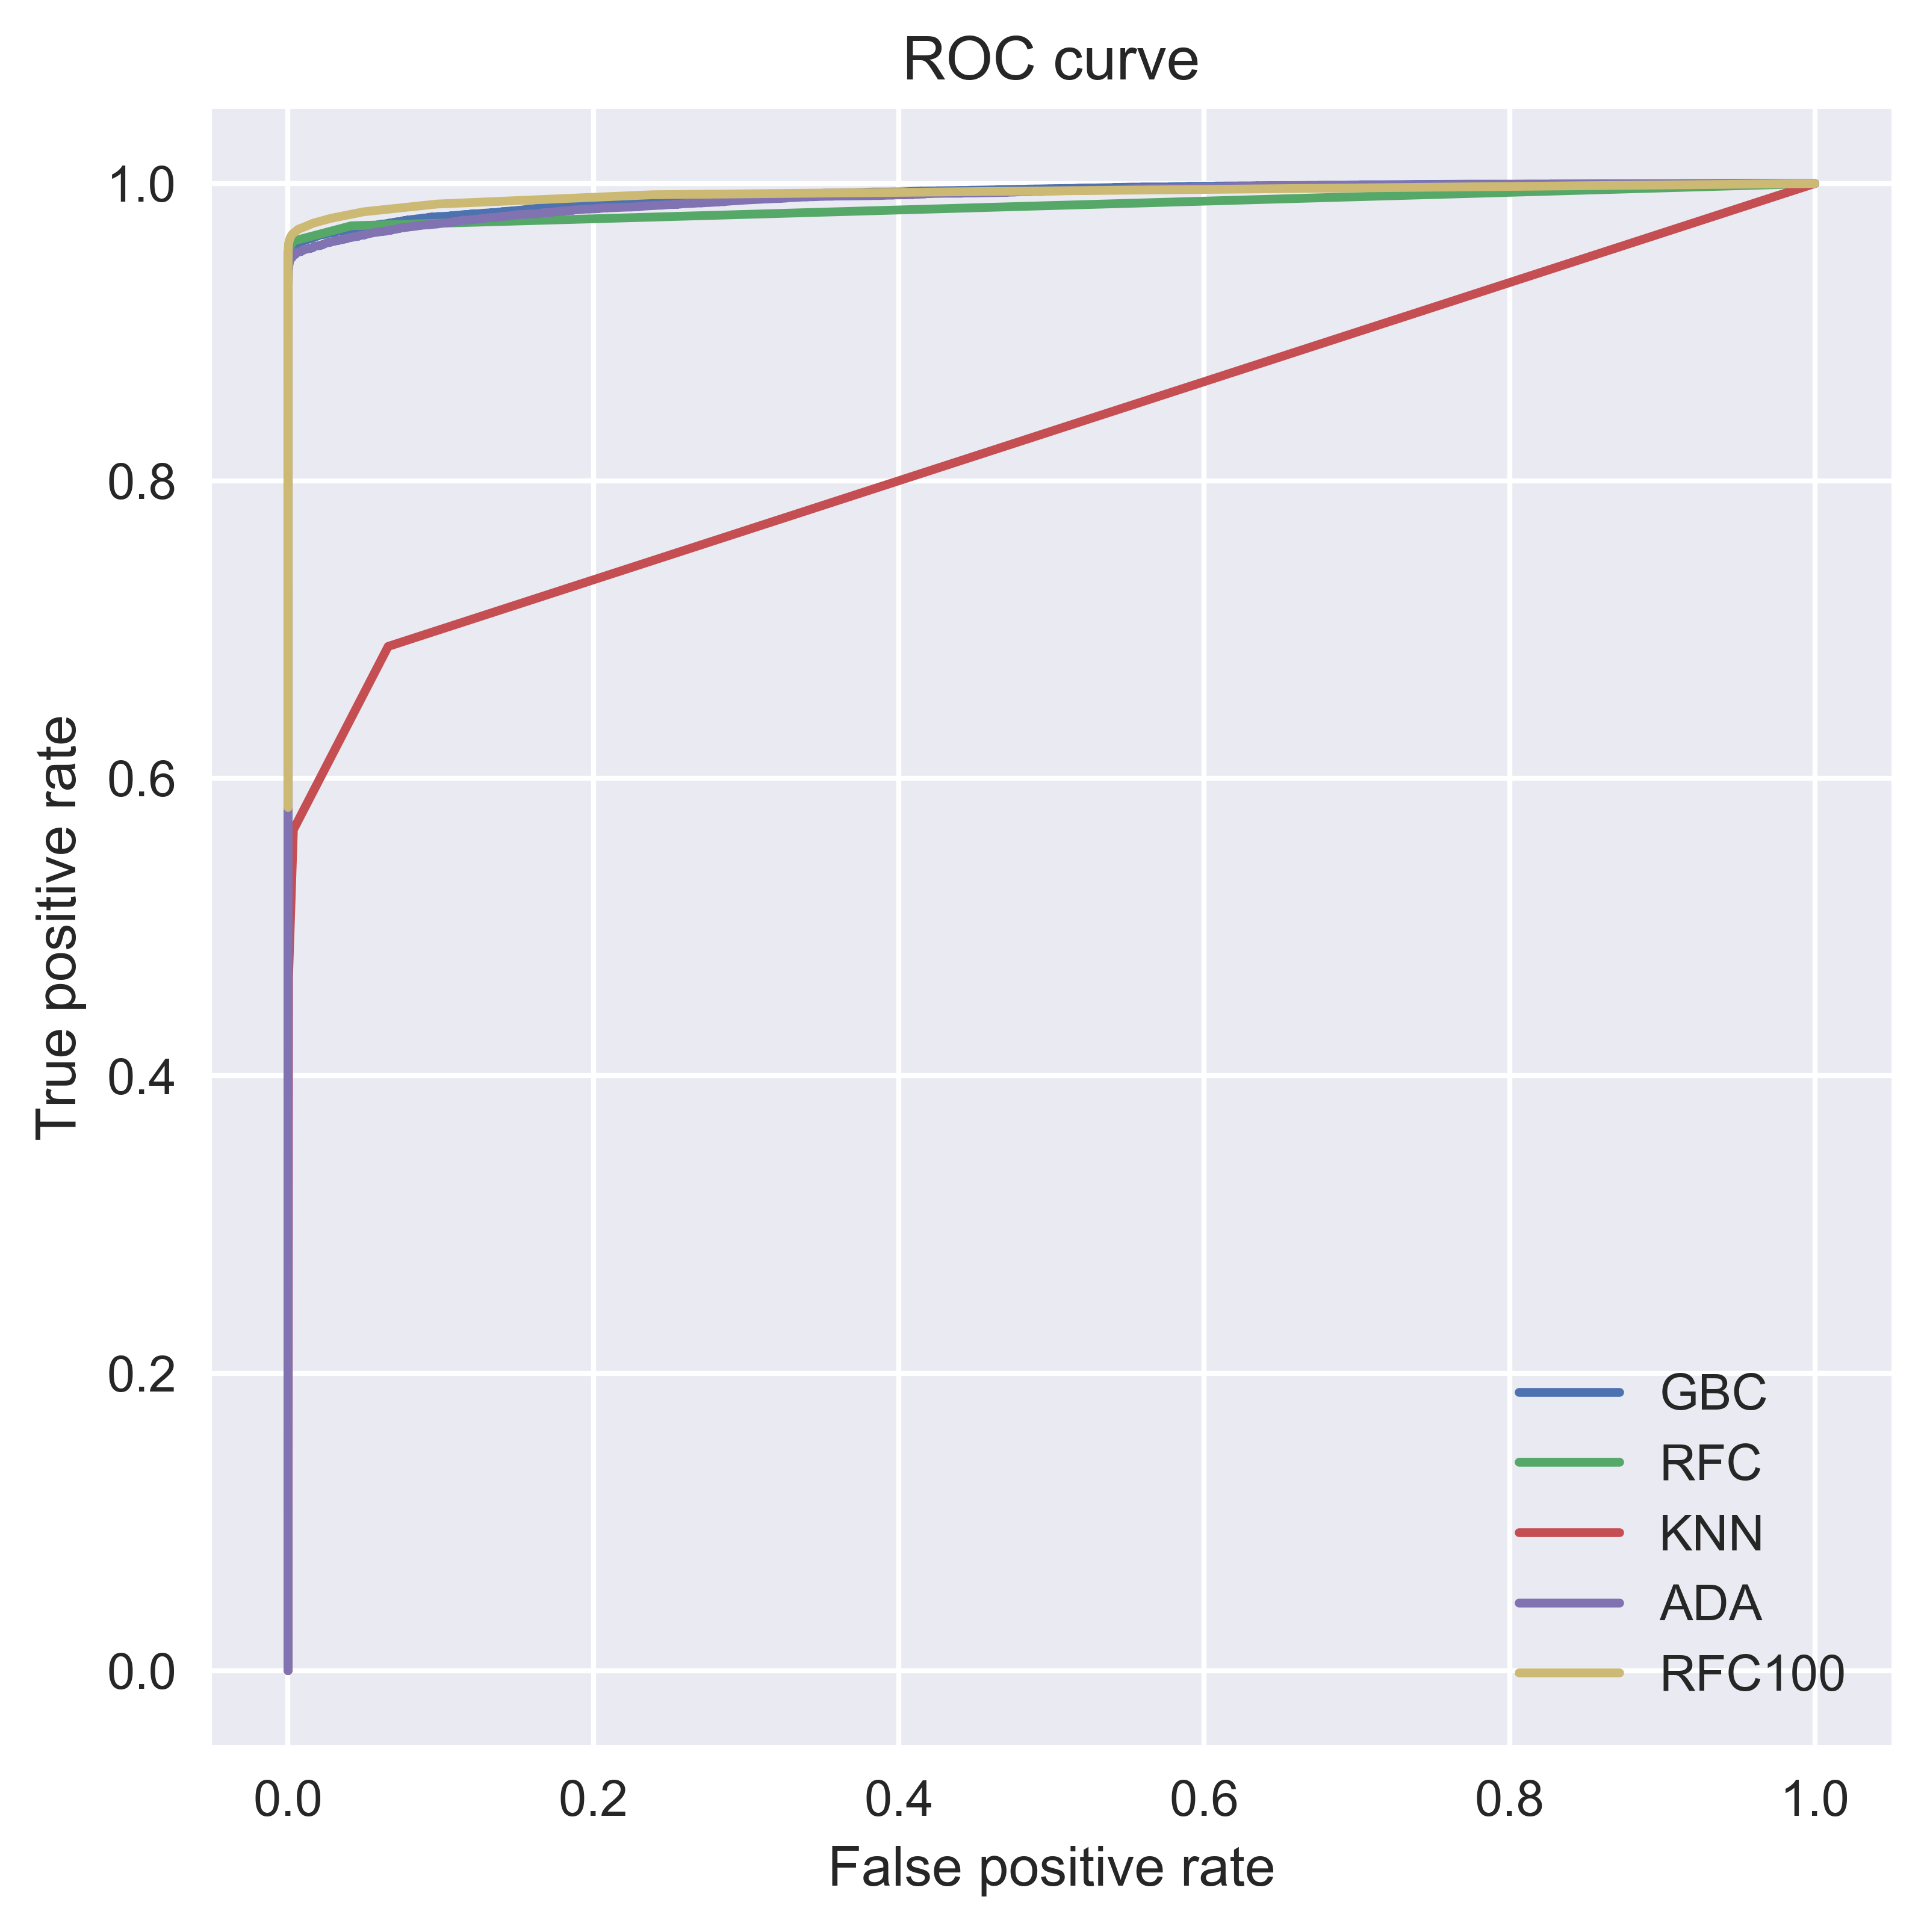

In [230]:
plt.figure(figsize=(width, height), dpi= 600)
matplotlib.rcParams['figure.figsize']= [12, 12]

clasifs_n = ['GBC','RFC','KNN','ADA','RFC100']
plt.plot(fprGBC, tprGBC , label='GBC')
plt.plot(fprRFC, tprRFC , label='RFC')
plt.plot(fprKNN, tprKNN , label='KNN')
plt.plot(fprADA, tprADA , label='ADA')
plt.plot(fprRFC100, tprRFC100, label='RFC100')

# show results
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# save results
plt.savefig('All_ROC.png')
plt.show()    

# 5.9 Saving results for future analysis

In [208]:
np.savetxt('ADA_results.out', (fprADA, tprADA))

In [209]:
np.savetxt('RFC_results.out', (fprRFC, tprRFC))

In [210]:
np.savetxt('KNN_results.out', (fprKNN, tprKNN))

In [211]:
np.savetxt('GBC_results.out', (fprGBC, tprGBC))

In [221]:
np.savetxt('RFC100_results.out', (fprRFC100, tprRFC100))

In [222]:
# saving dataframe for future use
data.to_csv('data_final_.csv')

# STOP